# Recuperação da Informação: 
## Estudo de caso em 20NewsGroups
---

## 0. Incializações

### 0.1 Importando bibliotecas

In [7]:
# Libs de sistema
import os
import string
from collections import defaultdict

# Libs para processamento do texto
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Libs para construção do modelo e avaliação
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix

# Libs para uso geral
import pandas as pd
import numpy as np
import importlib

# Libs de visualização
import seaborn as sns
import matplotlib.pyplot as plt

# Functions para o processamento do texto
from medidas_desempenho import *

# Lib de aceleração com GPU
import torch

# Load do device de processamento do torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device used:', device)

Device used: cuda:0


### 0.2 Carregando Dados

#### 0.2.1 Dados de treino

In [8]:
collection = 'data/20_newsgroups/'
themes = [collection+x+'/' for x in os.listdir(collection)]

x = []
y = []
for theme in themes:
    for file in os.listdir(theme):
        file_name = theme+file
        with open(file_name, 'r', encoding='ISO-8859-1') as fp:
            text = fp.readlines()
    
        x.append(text)
        y.append(theme.split('/')[2])

y = np.array(y)

#### 0.2.2 Dados de teste

In [9]:
collection = 'data/mini_newsgroups/'
themes = [collection+x+'/' for x in os.listdir(collection)]

x_test = []
y_test = []

for theme in themes:
    for file in os.listdir(theme):
        file_name = theme+file
        with open(file_name, 'r', encoding='ISO-8859-1') as fp:
            text = fp.readlines()
    
        x_test.append(text)
        y_test.append(theme.split('/')[2])

y_test = np.array(y_test)    

#### 0.2.3 Visualização dos Dados

In [10]:
print('Tamanho da coleção treino: ', len(x))
print('Tamanho da coleção para query: ', len(x_test))

Tamanho da coleção treino:  19997
Tamanho da coleção para query:  2000


In [11]:
print('Qnt. de classes trabalhadas: ', len(np.unique(y)))
print('Classes trabalhadas: ', np.unique(y))

Qnt. de classes trabalhadas:  20
Classes trabalhadas:  ['alt.atheism' 'comp.graphics' 'comp.os.ms-windows.misc'
 'comp.sys.ibm.pc.hardware' 'comp.sys.mac.hardware' 'comp.windows.x'
 'misc.forsale' 'rec.autos' 'rec.motorcycles' 'rec.sport.baseball'
 'rec.sport.hockey' 'sci.crypt' 'sci.electronics' 'sci.med' 'sci.space'
 'soc.religion.christian' 'talk.politics.guns' 'talk.politics.mideast'
 'talk.politics.misc' 'talk.religion.misc']


## 1. Pré-processamento do texto

### 1.0.1 Definição do método de stemmezar e lista de stopwords

In [12]:
lemmatizer = nltk.stem.WordNetLemmatizer()
stemmer = nltk.stem.PorterStemmer()
stop_words = set(nltk.corpus.stopwords.words('english'))
pontuacao = set(string.punctuation)
table = str.maketrans({x: ' ' for x in string.punctuation})

In [13]:
# Funções para processamento

def pre_process_word(word):
    # word = lemmatizer.lemmatize(word)
    word = stemmer.stem(word)
    return word

def pre_process_text(text):
    text = text.translate(table)
    text = nltk.tokenize.word_tokenize(text)
    return text

def word_allowed(word):
    if word in stop_words:
        return False

    if word in pontuacao:
        return False
        
    if word.isdecimal():
        return False

    if all(i in string.punctuation for i in word):
        return False
        
    return True

### 1.1 Remoção de Headers

Versão trabalhada foi a de 19997 documentos, sem limpeza inicial de cabeçalhos, quotes, rodapés.
Portanto, foram removidas inicialmente todos os headers para evitar overfitting devido à alguns hearders
conterem a classe do documento.

In [14]:
header_tokens = ['from', 'xref', 'path', 'newsgroups', 'date', 
                 'organization', 'lines', 'message-id', 
                 'reply-to', 'nntp-posting-host', 'sender', 
                 'references', 'in-reply-to', 'nf-id', 'nf-from', 'keywords',
                 'distribution', 'x-Newsreader', 'subject', 're', 'writes']

header_tokens = set(header_tokens)

#### 1.1.1 Processamento inicial para treino

In [15]:
x_processed = []
for text in x:
    aux = []
    for line in text[:20]:
        if line.split(':')[0].lower() in header_tokens:
            continue
        else:
            aux.append(line.lower())
                
    x_processed.append(''.join(aux))

#### 1.1.1 Processamento inicial para teste

In [16]:
x_test_processed = []
for text in x_test:
    aux = []
    for line in text[:20]:
        if line.split(':')[0].lower() in header_tokens:
            continue
        else:
            aux.append(line.lower())

    x_test_processed.append(''.join(aux))

### 1.2 Pipeline de processamento do texto

#### 1.2.1 Processamento para conj. treino

In [17]:
# Processa o texto como um todo, filtra, e processa palavra
aux_x = []
for text in x_processed:
    aux_x.append(' '.join([pre_process_word(word) for word in filter(word_allowed, pre_process_text(text))]))

x_processed = aux_x

#### 1.2.2 Processamento para conj. teste

In [18]:
aux_x = []
for text in x_test_processed:
    aux_x.append(' '.join(pre_process_word(word) for word in filter(word_allowed, pre_process_text(text))))

x_test_processed = aux_x

#### 1.2.3 Limpeza de textos problemáticos

Existem documentos com texto não condizentes com a classe pertencentes (textos que foram removidos em versões mais recentes)

Exemplos:

In [19]:
[x_processed[idx] for idx, text in enumerate(x_processed) if (len(text) < 15)][:10]

['shut andi', 'kid', '', '', '', 'test', 'need say', 'test messag', '', 'test']

In [20]:
[x_test_processed[idx] for idx, text in enumerate(x_test_processed) if (len(text) < 15)]

['', 'need say']

In [21]:
drop_train = [idx for idx, text in enumerate(x_processed) if (len(text) < 15)]
drop_test = [idx for idx, text in enumerate(x_test_processed) if (len(text) < 15)]

In [22]:
x_processed = np.delete(x_processed, drop_train)
x_test_processed = np.delete(x_test_processed, drop_test)

y = np.delete(y, drop_train)
y_test = np.delete(y_test, drop_test)

In [23]:
print('Novo tamanho de treino e teste:', len(x_processed), len(x_test_processed))

Novo tamanho de treino e teste: 19943 1998


### 1.3 Visualizando o pré-processamento

In [67]:
# Gera a matriz de contagem de ocorrência do termo por documento

counter_vectorizer = CountVectorizer()
counter_matrix = counter_vectorizer.fit_transform(x_processed)
counter = pd.DataFrame(counter_matrix.todense(), columns=counter_vectorizer.get_feature_names_out())

In [68]:
print('Tamanho do vocabulário inicial: ', len(counter.columns))

Tamanho do vocabulário inicial:  41630


In [69]:
print('Maiores ocorrências de palavras na coleção: ')
pd.DataFrame(counter.sum(axis=0).sort_values(ascending=False).tail(10), columns=['Ocorrência'])

Maiores ocorrências de palavras na coleção: 


Ocorrência
haanpaa                                     1
haan                                        1
haabn                                       1
haab                                        1
haaaaaaaaaahahahahahahahahahahaha           1
haaaa                                       1
haaa                                        1
h9is0c77a6h                                 1
h9g                                         1
ÿhook                                       1

#### 1.3.1 Redução no vocabulário

In [72]:
c = counter.sum(axis=0)
size_reduction = {v: np.where(c>v)[0].shape[0] for v in range(100)}

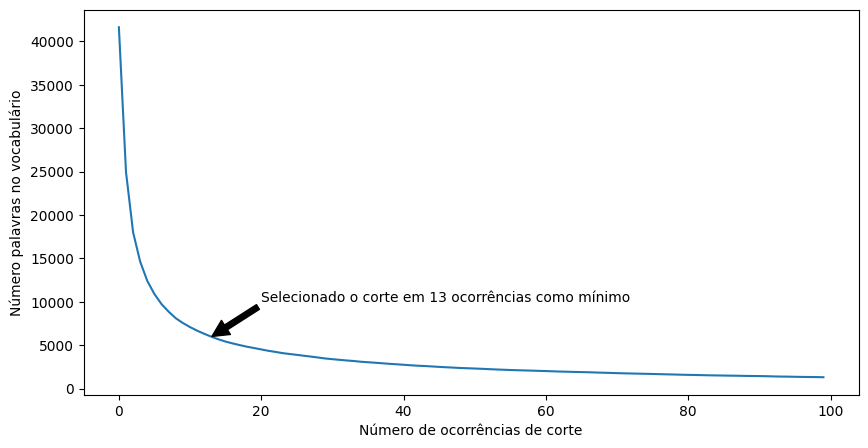

In [73]:
fig = plt.figure(figsize=(10, 5))
sns.lineplot(data=size_reduction)
plt.annotate('Selecionado o corte em 13 ocorrências como mínimo', xy=(13, size_reduction[13]), xytext=(20, 10000),
            arrowprops=dict(facecolor='black', shrink=0.01),
            )
plt.xlabel('Número de ocorrências de corte')
plt.ylabel('Número palavras no vocabulário')
plt.savefig('figures/PlotOcorr.png')

In [74]:
counter = counter.loc[:, counter.sum(axis=0).sort_values()>13]

In [75]:
vocabulary = counter.columns.tolist()

# Remoção de algumas palavras com alto valor de ocorrência
vocabulary.remove('edu')
vocabulary.remove('articl')
vocabulary.remove('com')
vocabulary.remove('write')

In [77]:
print('Novo tamanho de vocabulário: ', len(vocabulary))

Novo tamanho de vocabulário:  5982


### 1.4 Calculo de TF-IDF 

In [32]:
# Recontagem baseado no vocabulário reduzido

counter_vectorizer = CountVectorizer(vocabulary=vocabulary)
counter_matrix = counter_vectorizer.fit_transform(x_processed)
counter = pd.DataFrame(counter_matrix.todense(), columns=counter_vectorizer.get_feature_names_out())

In [33]:
# Cálculo do TF-IDF para a modelagem

tfidf_vectorizer = TfidfTransformer()
tfidf_matrix = tfidf_vectorizer.fit_transform(counter_matrix)
tfidf = pd.DataFrame(tfidf_matrix.todense(), columns=counter_vectorizer.get_feature_names_out())

In [34]:
# Contagem de ocorrências no conjunto de teste

counter_matrix_test = counter_vectorizer.transform(x_test_processed)
counter_test = pd.DataFrame(counter_matrix_test.todense(), columns=counter_vectorizer.get_feature_names_out())

In [35]:
# Calculo do TF-IDF para as queries em relação aos termos da coleção

tfidf_test_matrix = tfidf_vectorizer.transform(counter_matrix_test)
tfidf_test = pd.DataFrame(tfidf_test_matrix.todense(), columns=tfidf_vectorizer.get_feature_names_out())

---
## 2. Modelagem

### 2.1 Modelo vetorial

#### 2.1.1 Load dos modelos (Arquivo Models)

In [37]:
from modelos import ModeloVetorial
labels = sorted(np.unique(y))
precisions_calc = [10, 20, 50, 100]

#### 2.1.2 Geração do modelo e treinamento

In [38]:
md = ModeloVetorial()
md.fit(x=tfidf, y=y)

#### 2.1.3 Predição das queries

In [39]:
predict = []
for query_test in tfidf_test.values:
    predict.append(md.predict(query_test))

#### 2.1.4 Calculo das medidas de desempenho

In [40]:
measures = pd.DataFrame([calcula_measures(y_pred, y_true, precisions_calc + ['map']) for y_pred, y_true in zip(predict, y_test)])

In [41]:
# Calculo das matrizes de confusão
cf_per_prec = {}

for prec in precisions_calc:
    cf_per_prec[prec] = np.zeros(shape=(len(labels), len(labels)))

for y_pred, y_true in zip(predict, y_test):
    for prec, cf in calcula_matriz_confusao(y_pred, y_true, precisions_calc, labels=np.unique(y)).items():
        cf_per_prec[prec] += cf

#### 2.1.5 Visualização dos resultados

In [42]:
r_vetorial = pd.DataFrame(measures)

In [43]:
pd.DataFrame(r_vetorial.mean()).T

P@10      P@20      P@50     P@100       MAP
0  0.598949  0.495896  0.389239  0.320811  0.215427

In [44]:
r_vetorial.insert(0, 'Class', y_test)

In [45]:
r_vetorial.groupby(by='Class').mean().sort_values(by='P@10', ascending=False)

P@10      P@20      P@50     P@100       MAP
Class                                                                     
soc.religion.christian    0.791000  0.747500  0.679200  0.635900  0.628122
talk.politics.mideast     0.786000  0.684000  0.543800  0.445200  0.235497
rec.sport.hockey          0.749495  0.602525  0.472929  0.399293  0.270666
sci.space                 0.725000  0.623500  0.513000  0.411200  0.236303
sci.crypt                 0.688000  0.578000  0.454000  0.386400  0.247576
alt.atheism               0.652000  0.576500  0.460000  0.364200  0.195849
rec.motorcycles           0.643000  0.507500  0.360400  0.278900  0.180507
rec.sport.baseball        0.643000  0.518500  0.399000  0.310800  0.193296
talk.politics.guns        0.620000  0.511000  0.369600  0.278100  0.173865
talk.politics.misc        0.586000  0.505000  0.387800  0.300600  0.156264
sci.med                   0.553000  0.448000  0.344000  0.282300  0.166477
rec.autos                 0.535354  0.427273  0.310505  0.245758  0.172022
comp.sys.ibm.pc.hardware  0.529000  0.454000  0.362400  0.296700  0.202477
talk.religion.misc        0.520000  0.419000  0.307800  0.237400  0.144458
comp.sys.mac.hardware     0.512000  0.408500  0.333000  0.286000  0.206764
comp.os.ms-windows.misc   0.504000  0.405500  0.320800  0.287900  0.216939
comp.graphics             0.503000  0.402000  0.311400  0.255100  0.185412
comp.windows.x            0.497000  0.382500  0.316800  0.276900  0.190231
sci.electronics           0.496000  0.355000  0.242200  0.193600  0.127029
misc.forsale              0.447000  0.362500  0.296200  0.244000  0.178911

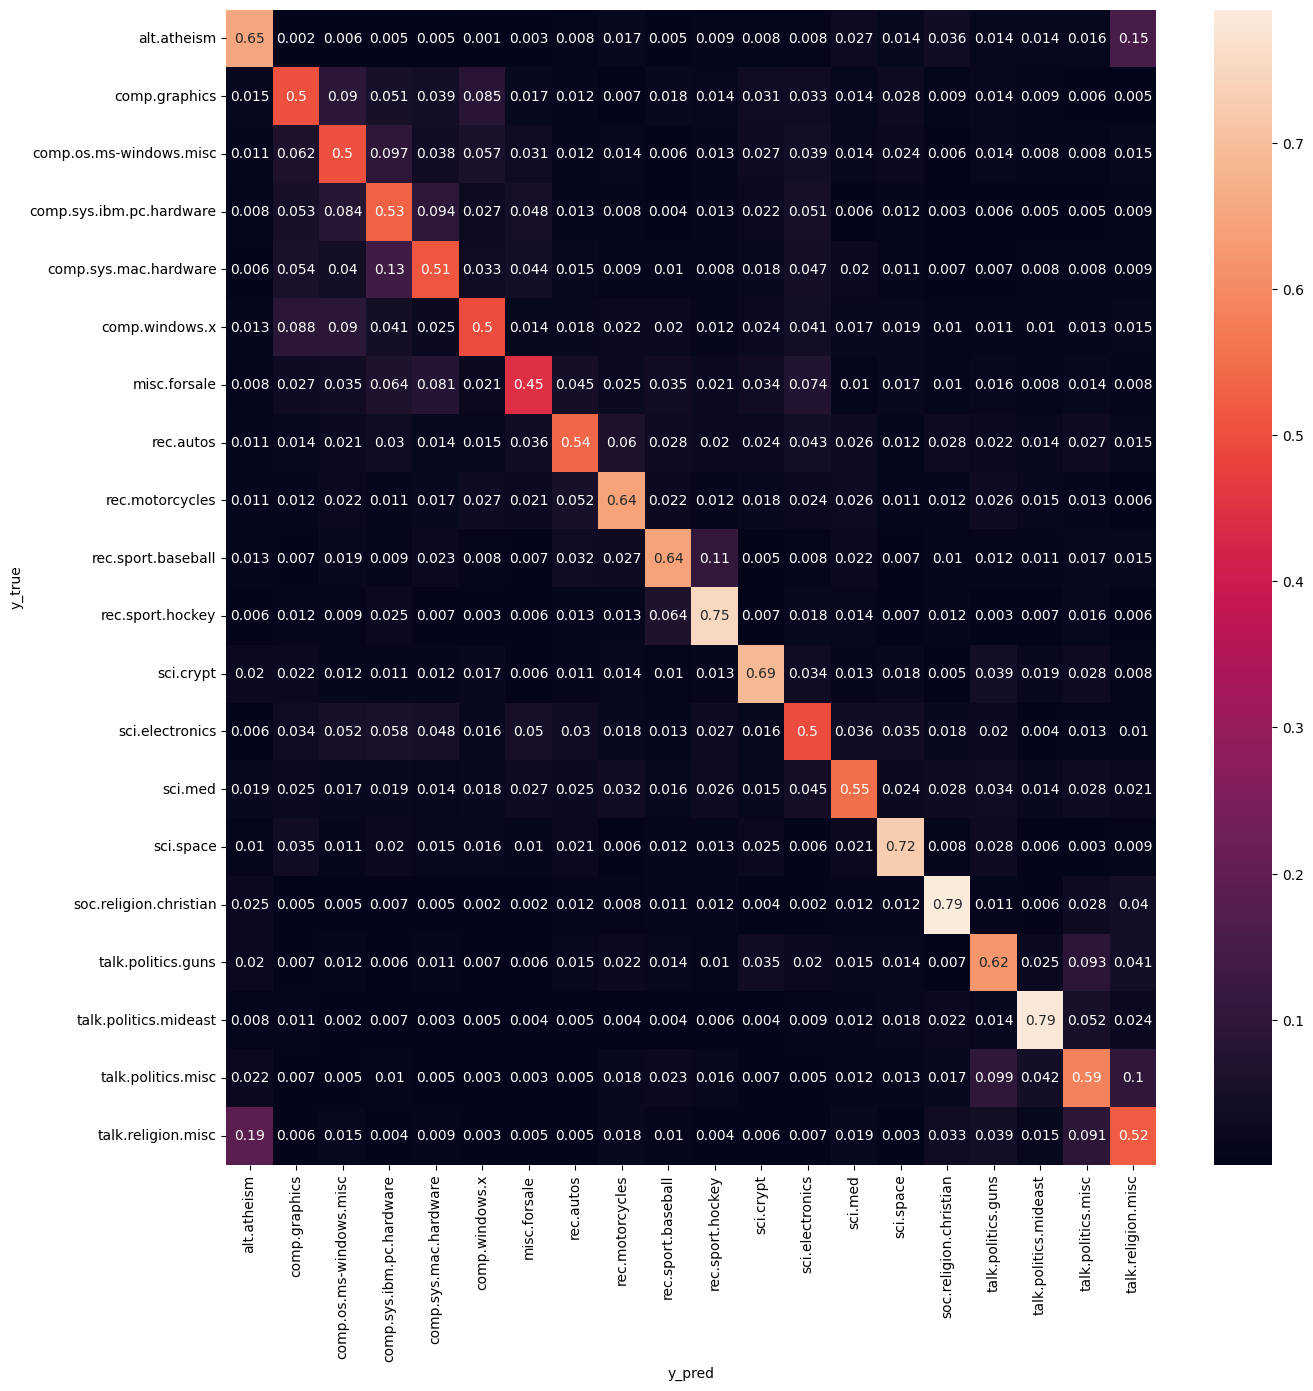

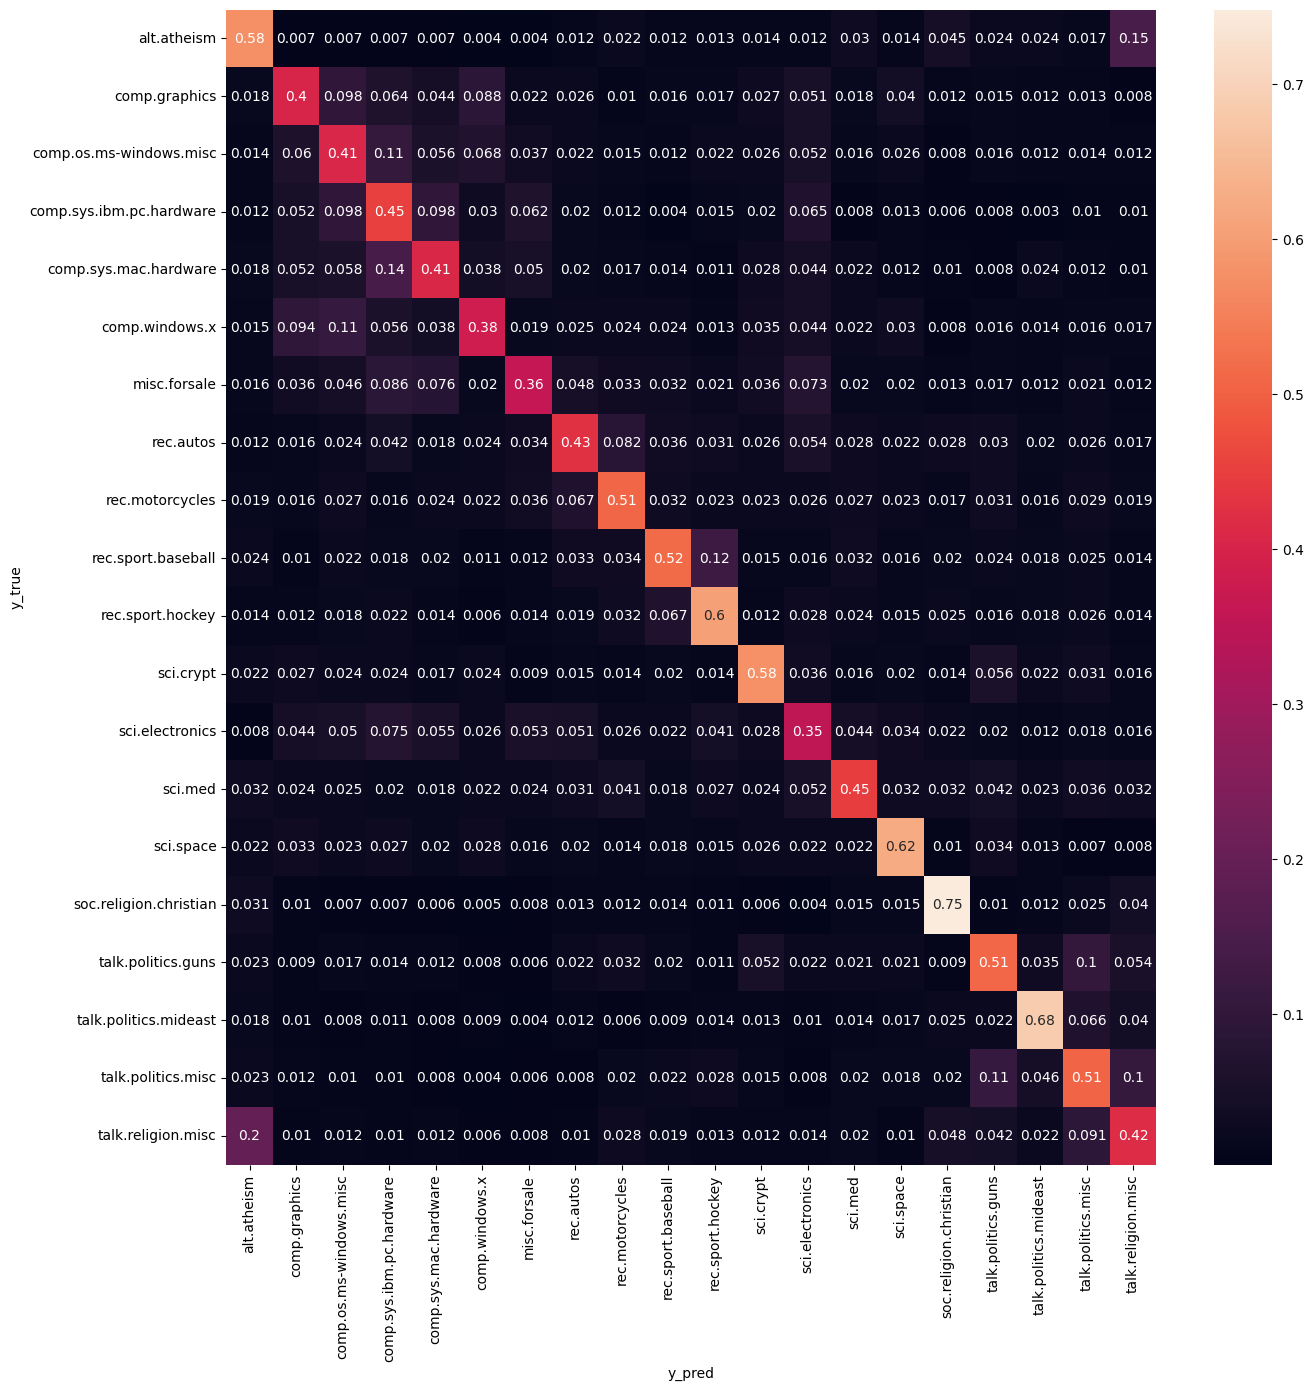

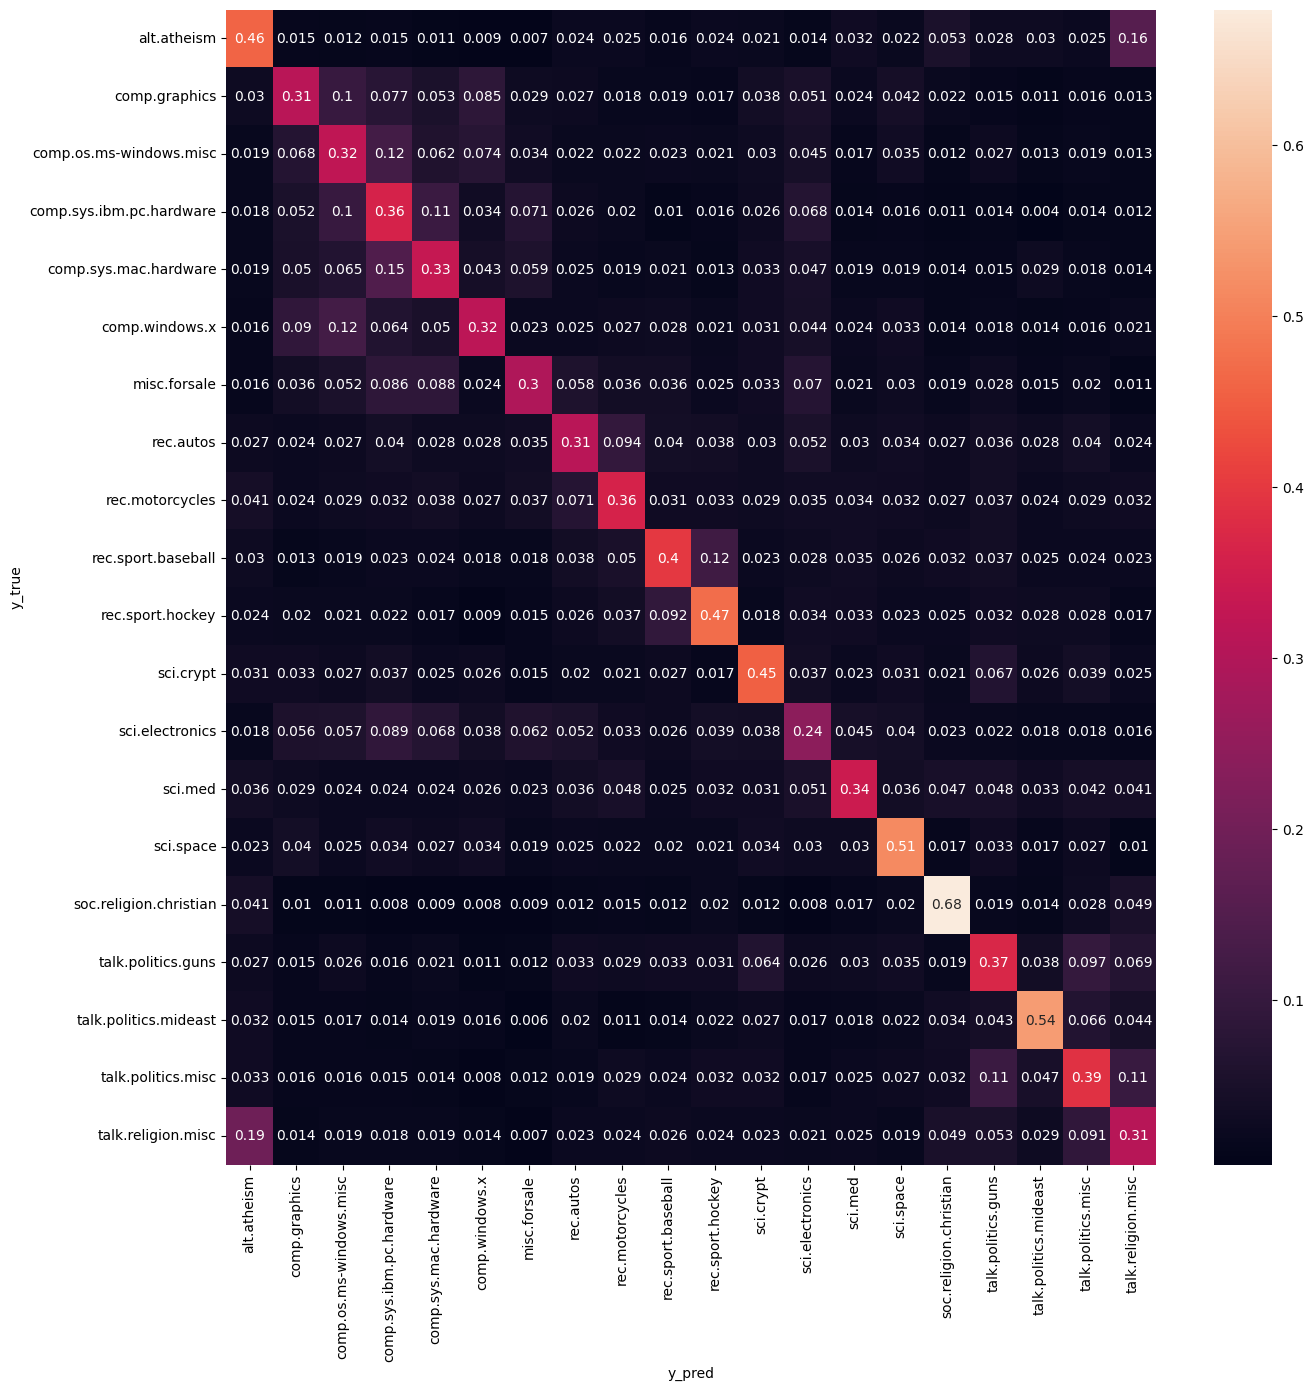

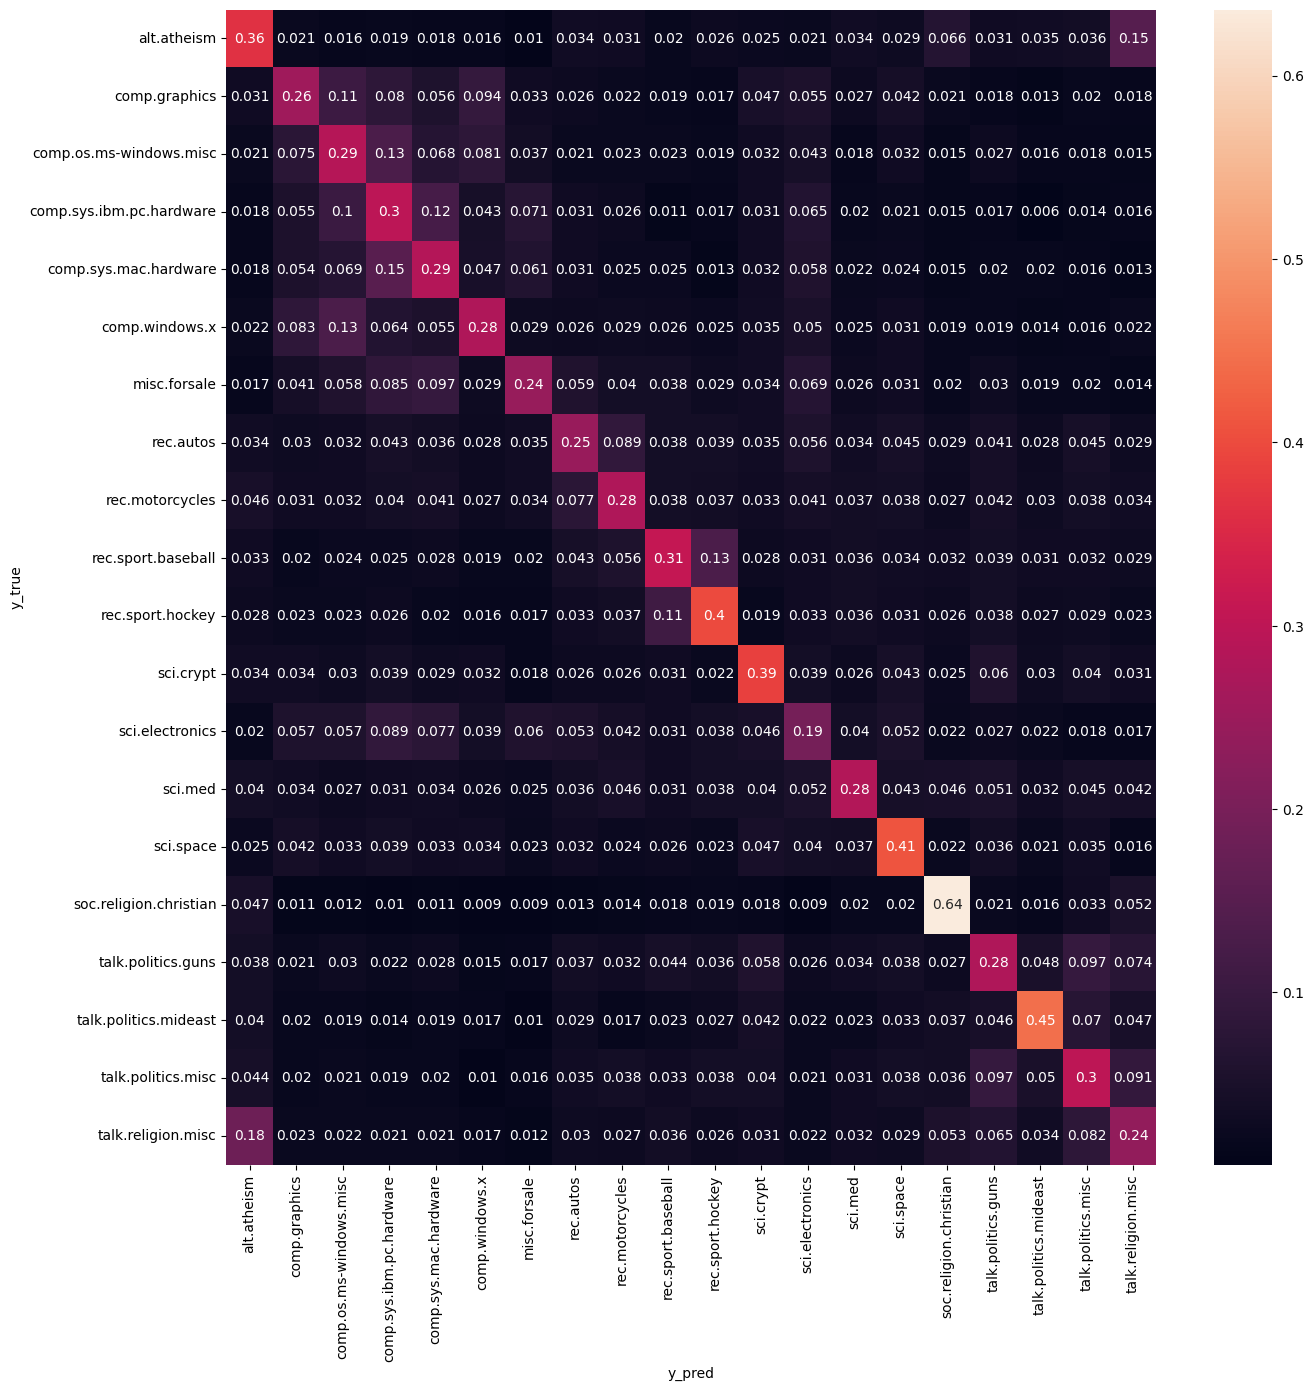

In [46]:
for prec in precisions_calc:
    v = pd.DataFrame(np.around(cf_per_prec[prec]/cf_per_prec[prec].sum(axis=1), 3), columns=labels, index=labels)
    
    fig = plt.figure(figsize=(15, 15))
    sns.heatmap(v, annot=True)
    plt.ylabel('y_true')
    plt.xlabel('y_pred')
    fig.savefig(f'figures/cf_matrix/cf_{prec}.png', bbox_inches='tight')

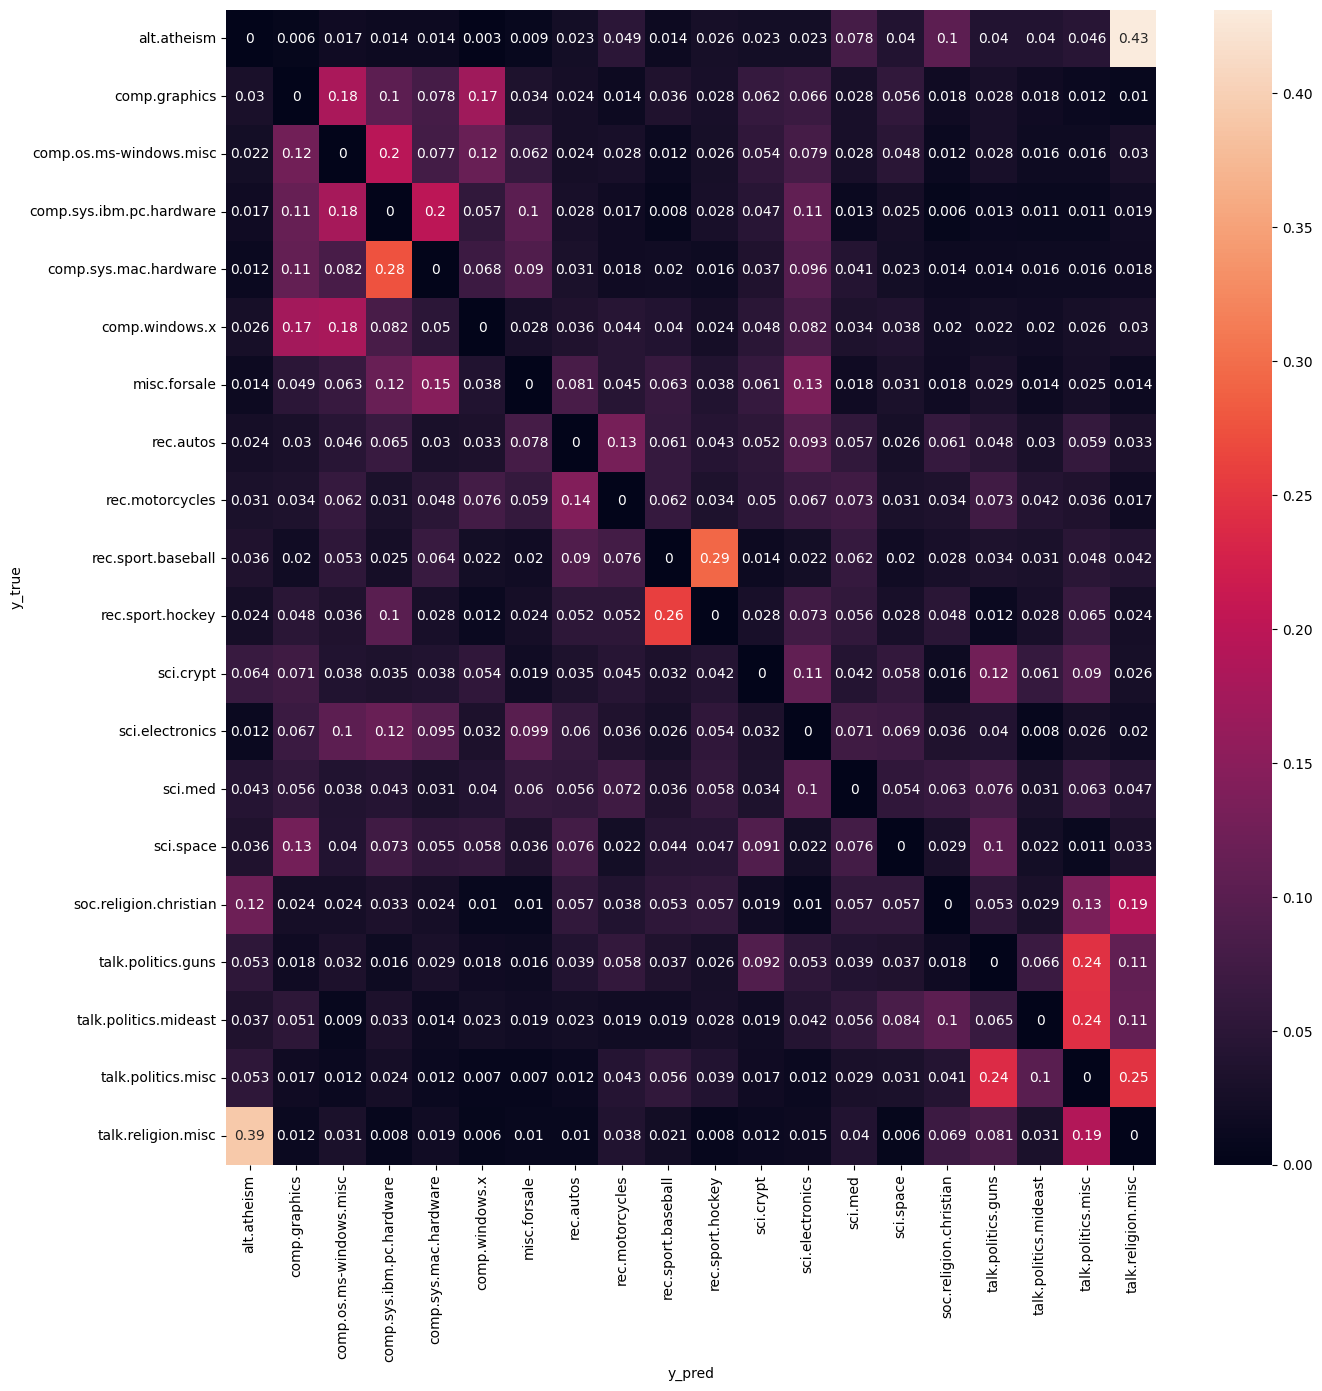

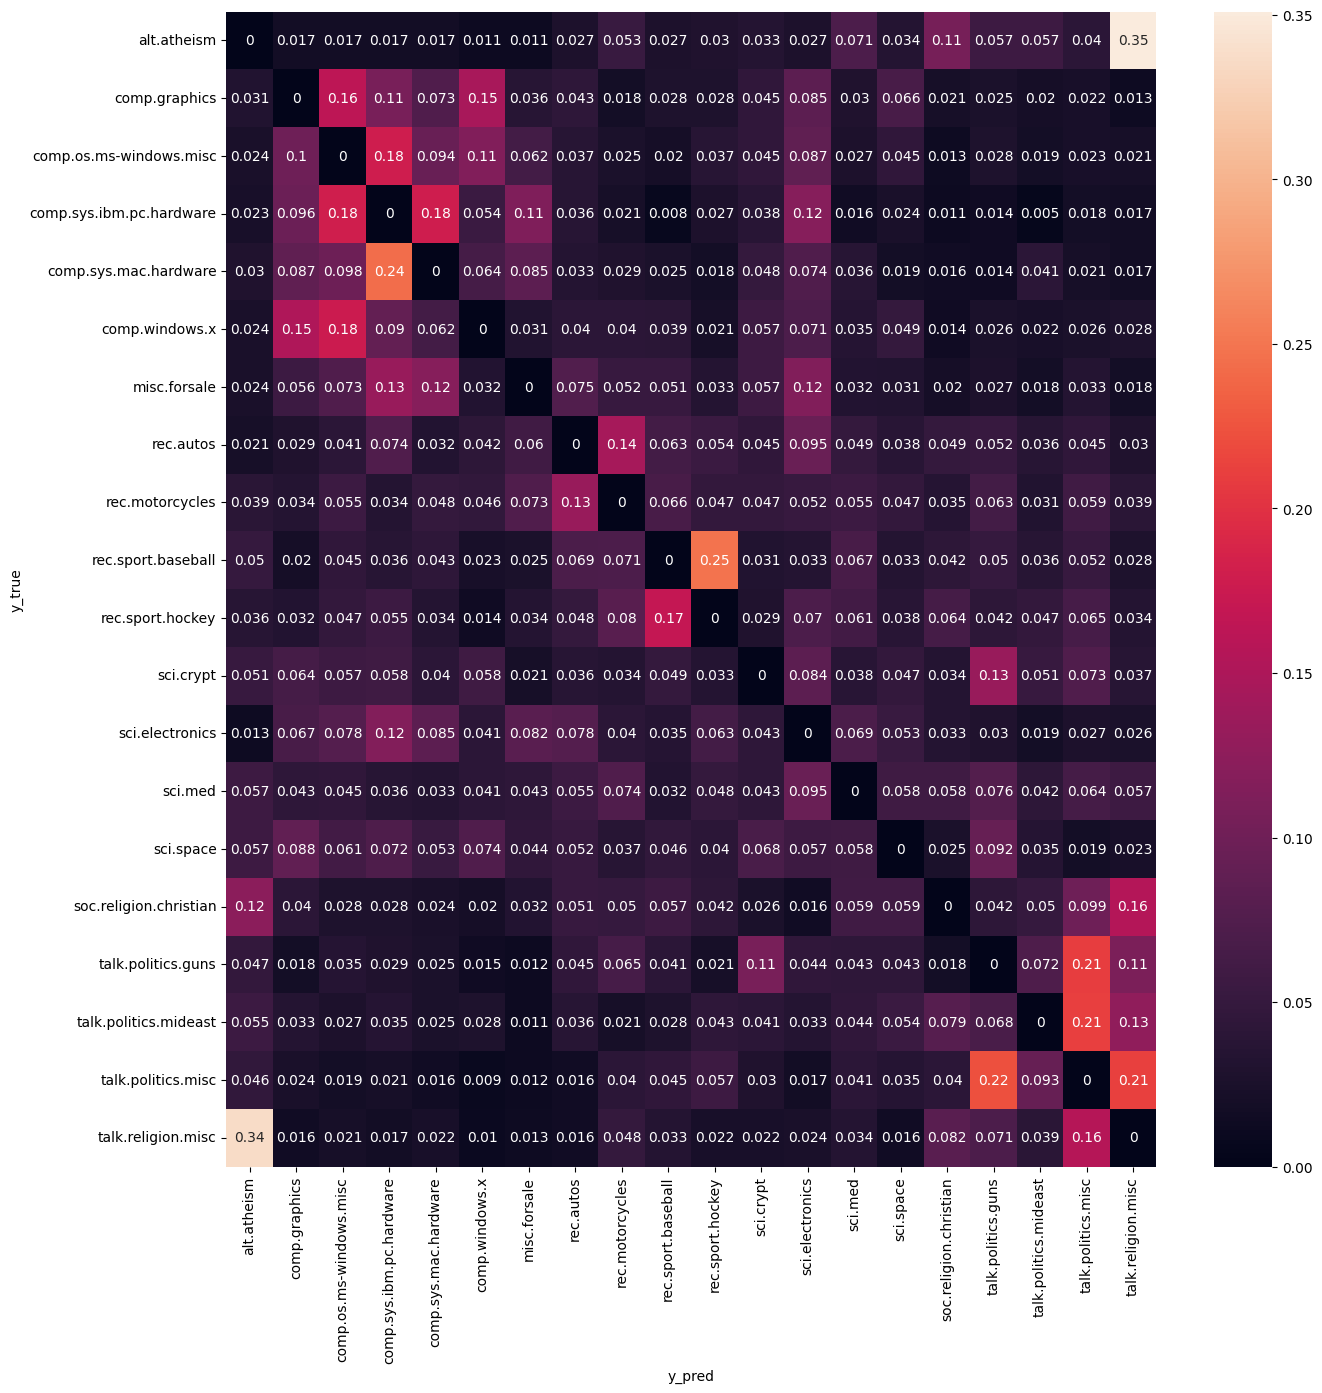

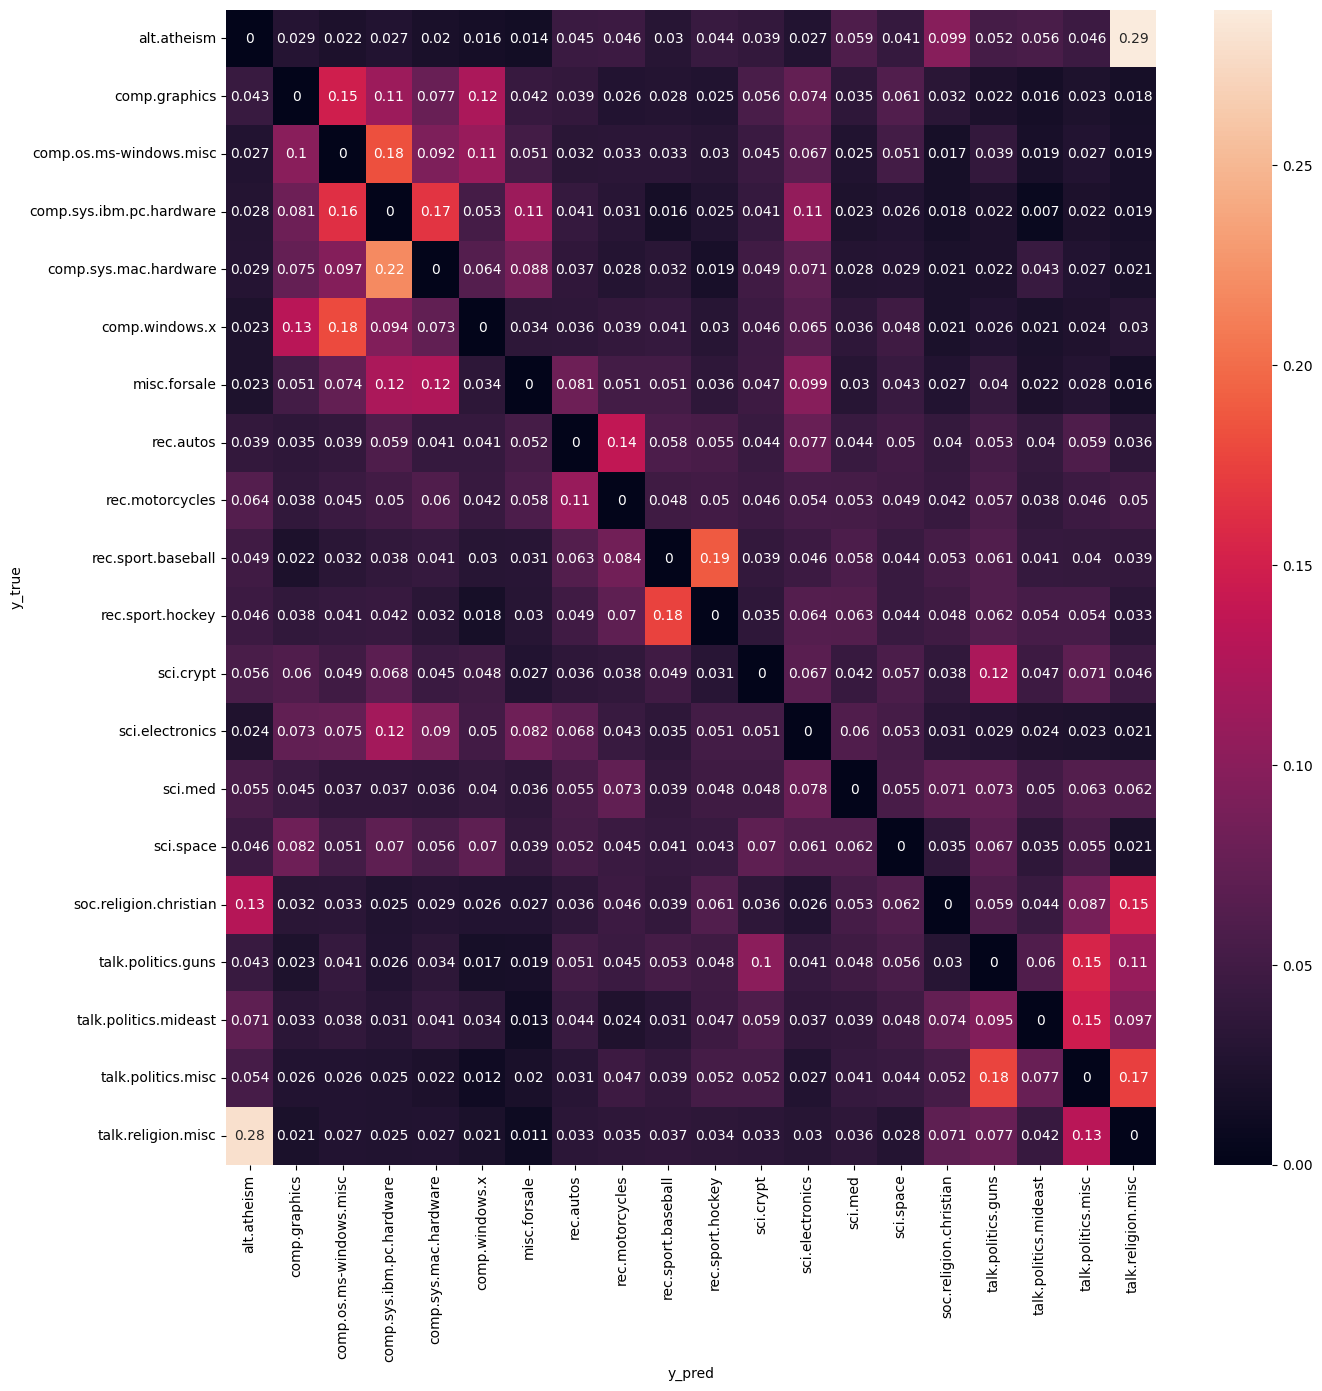

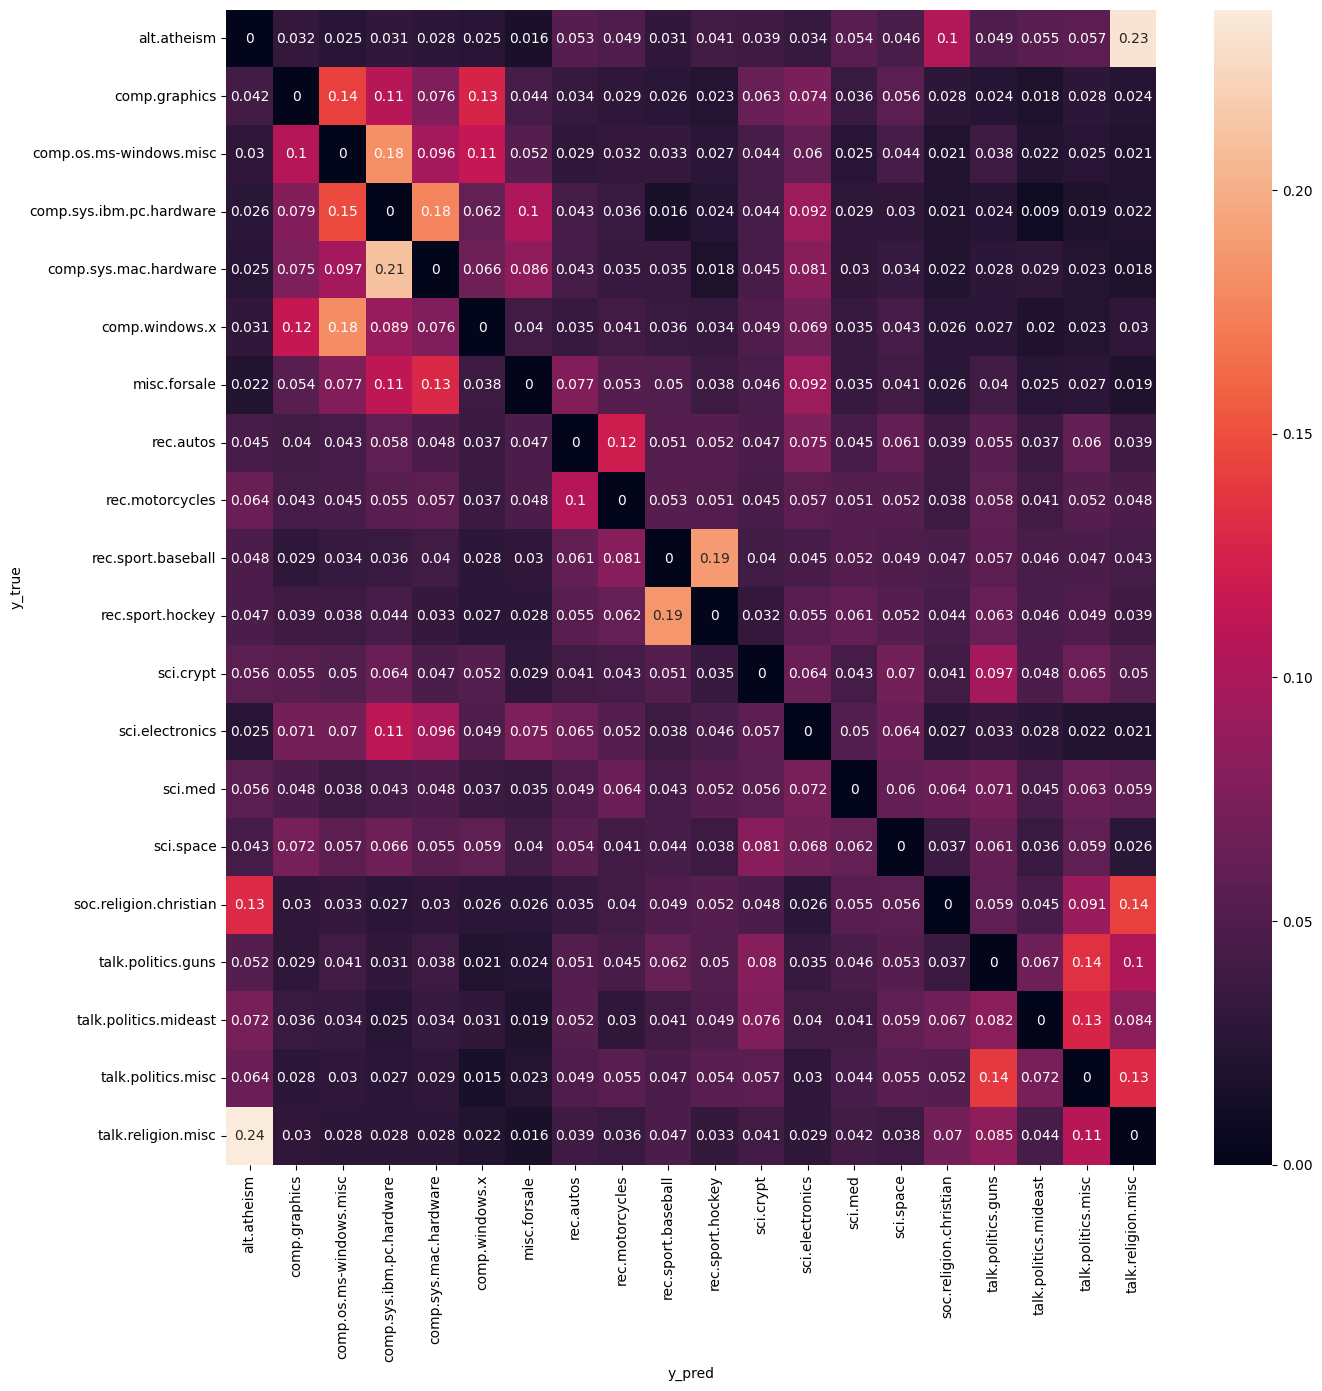

In [47]:
for prec in precisions_calc:
    v = pd.DataFrame(np.around(fill_diagonal(cf_per_prec[prec], 0)/fill_diagonal(cf_per_prec[prec], 0).sum(axis=1).reshape(-1, 1), 3), columns=labels, index=labels)
    
    fig = plt.figure(figsize=(15, 15))
    sns.heatmap(v, annot=True)
    plt.ylabel('y_true')
    plt.xlabel('y_pred')
    fig.savefig(f'figures/cf_matrix/cf_diagonal_0_{prec}.png', bbox_inches='tight')

### 2.2 Modelo Probabilistico (BM25)

#### 2.2.1 Load dos modelos (Arquivo Models)

In [48]:
from modelos import ModeloBM25

#### 2.2.2 Geração do modelo e treinamento

In [49]:
model_bm25 = ModeloBM25()
model_bm25.fit(x=counter, y=y)

#### 2.2.3 Predição das queries

In [50]:
predict_bm25 = []
for query_test in tfidf_test.values:
    predict_bm25.append(model_bm25.predict(query_test))

#### 2.2.4 Calculo das medidas de desempenho

In [51]:
measures_bm25 = pd.DataFrame([calcula_measures(y_pred, y_true, precisions_calc + ['map']) for y_pred, y_true in zip(predict_bm25, y_test)])

In [52]:
# Calculo das matrizes de confusão
cf_per_prec_bm25 = {}

for prec in precisions_calc:
    cf_per_prec_bm25[prec] = np.zeros(shape=(len(labels), len(labels)))

for y_pred, y_true in zip(predict_bm25, y_test):
    for prec, cf in calcula_matriz_confusao(y_pred, y_true, precisions_calc, labels=np.unique(y)).items():
        cf_per_prec_bm25[prec] += cf

#### 2.1.4 Visualização dos resultados

In [53]:
r_vetorial_bm25 = pd.DataFrame(measures_bm25)

In [54]:
pd.DataFrame(r_vetorial_bm25.mean()).T

P@10      P@20      P@50     P@100       MAP
0  0.611161  0.513789  0.403093  0.329755  0.218093

In [55]:
r_vetorial_bm25.insert(0, 'Class', y_test)

In [56]:
r_vetorial_bm25.groupby(by='Class').mean().sort_values(by='P@10', ascending=False)

P@10      P@20      P@50     P@100       MAP
Class                                                                     
soc.religion.christian    0.977000  0.978500  0.980600  0.981000  0.956303
talk.politics.mideast     0.761000  0.663000  0.504000  0.369500  0.183646
rec.sport.hockey          0.747475  0.634343  0.497980  0.412626  0.256797
sci.crypt                 0.713000  0.606000  0.455800  0.362500  0.212493
sci.space                 0.683000  0.592000  0.461800  0.352500  0.191355
alt.atheism               0.674000  0.597500  0.473800  0.374700  0.192594
rec.motorcycles           0.648000  0.511000  0.340800  0.240800  0.148707
talk.politics.guns        0.616000  0.513000  0.374200  0.278100  0.151719
rec.sport.baseball        0.605000  0.492000  0.348600  0.272900  0.170832
talk.politics.misc        0.586000  0.486500  0.376800  0.282000  0.142794
comp.sys.mac.hardware     0.582000  0.480000  0.379600  0.315800  0.197779
comp.os.ms-windows.misc   0.580000  0.492000  0.409400  0.347500  0.242393
rec.autos                 0.553535  0.422222  0.299394  0.233737  0.150410
comp.sys.ibm.pc.hardware  0.542000  0.447500  0.359800  0.295800  0.203934
sci.med                   0.535000  0.400500  0.275400  0.208100  0.131585
comp.windows.x            0.513000  0.428000  0.345200  0.296700  0.194663
talk.religion.misc        0.513000  0.437500  0.346800  0.280900  0.156090
sci.electronics           0.490000  0.350500  0.241800  0.184300  0.124994
misc.forsale              0.458000  0.382500  0.303400  0.259200  0.177461
comp.graphics             0.447000  0.361500  0.286600  0.246300  0.175018

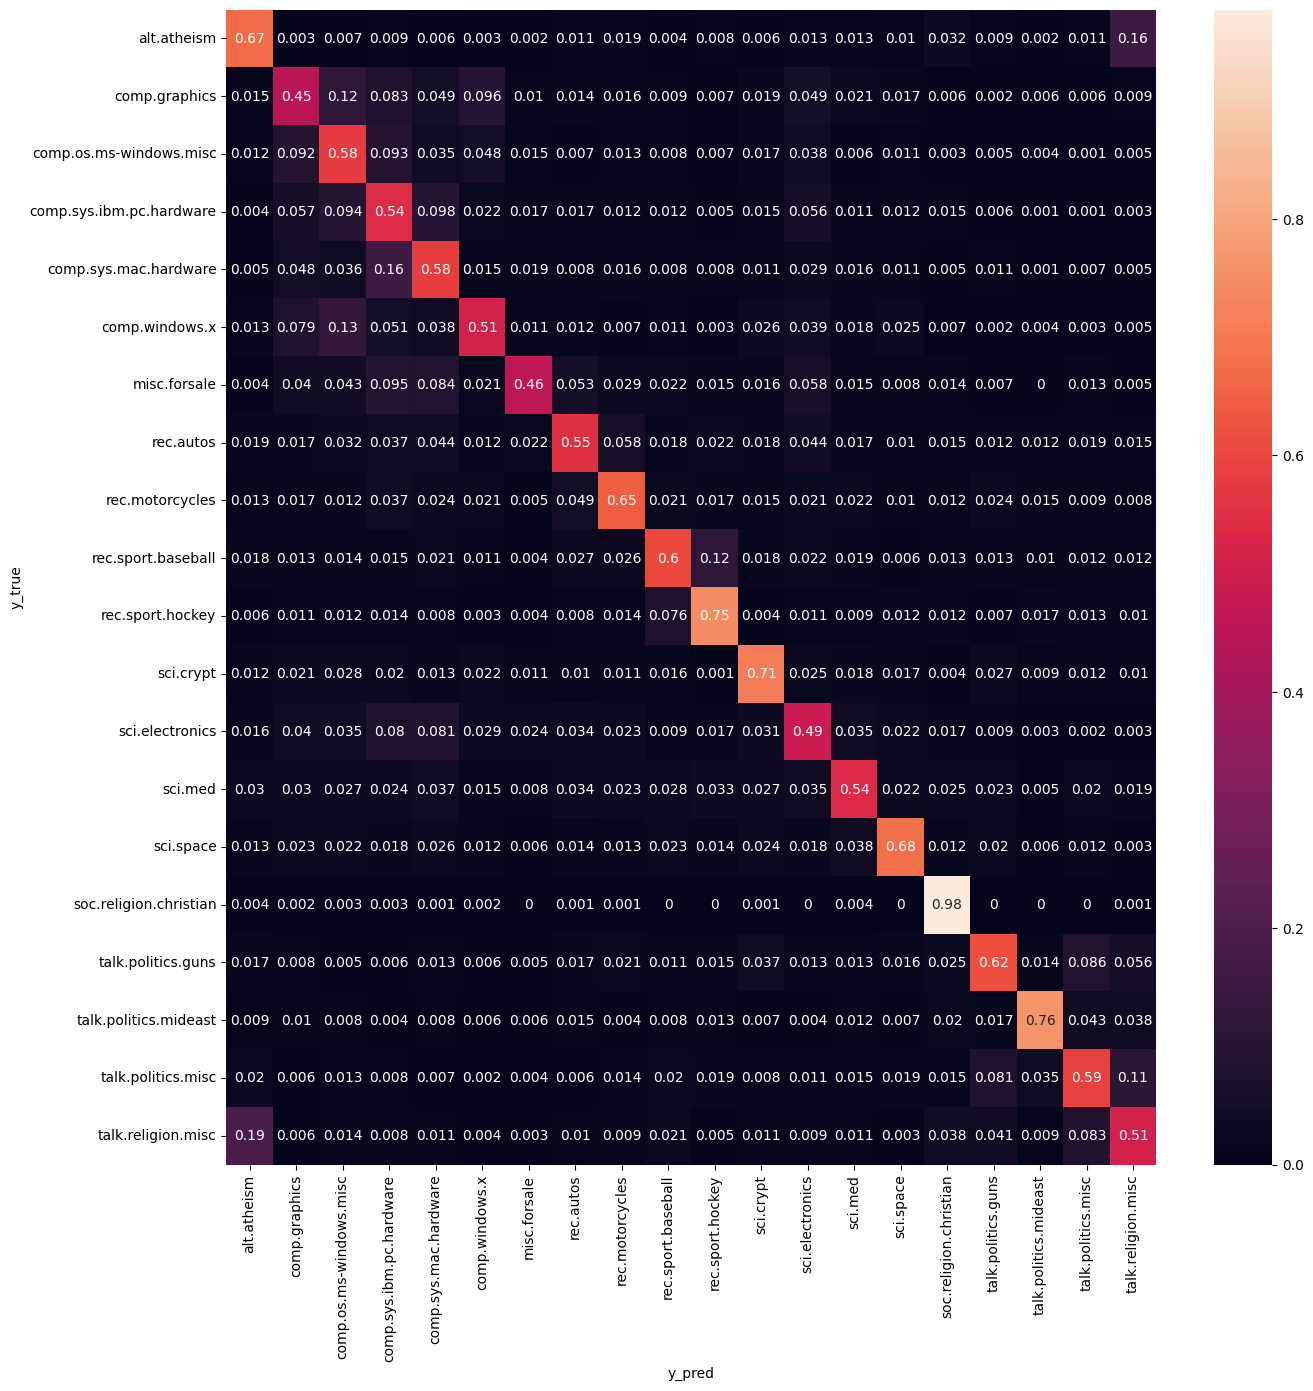

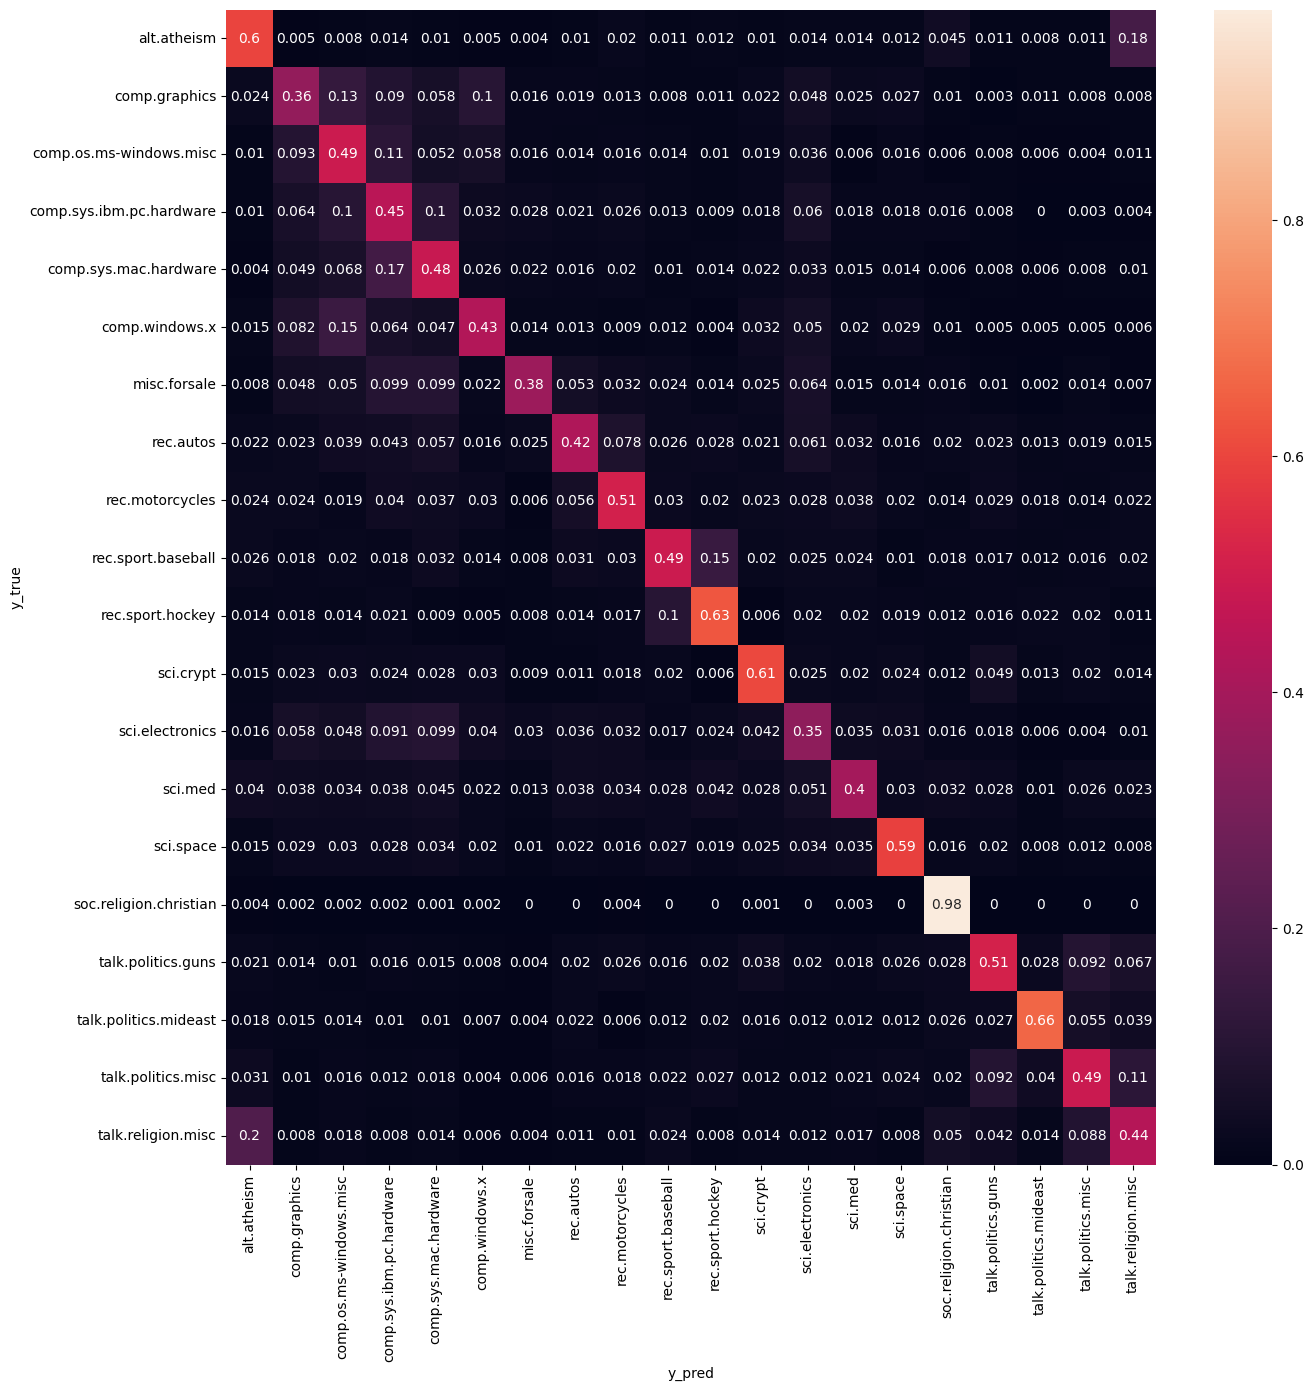

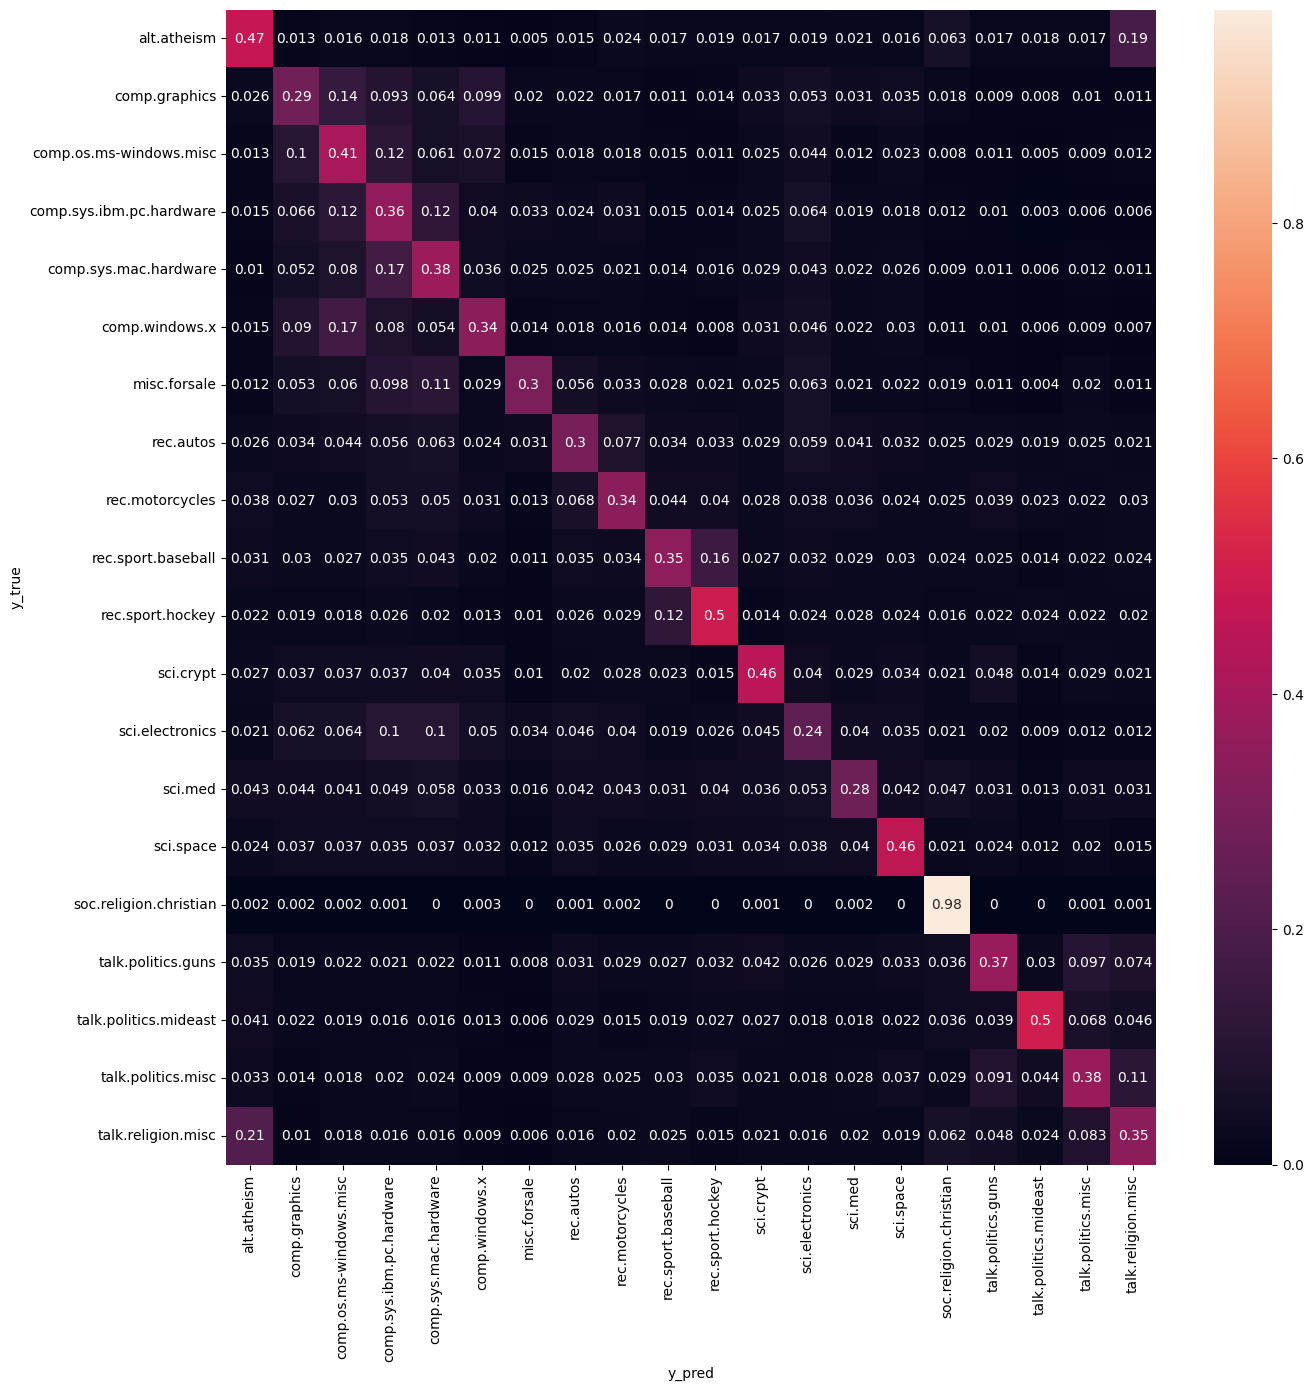

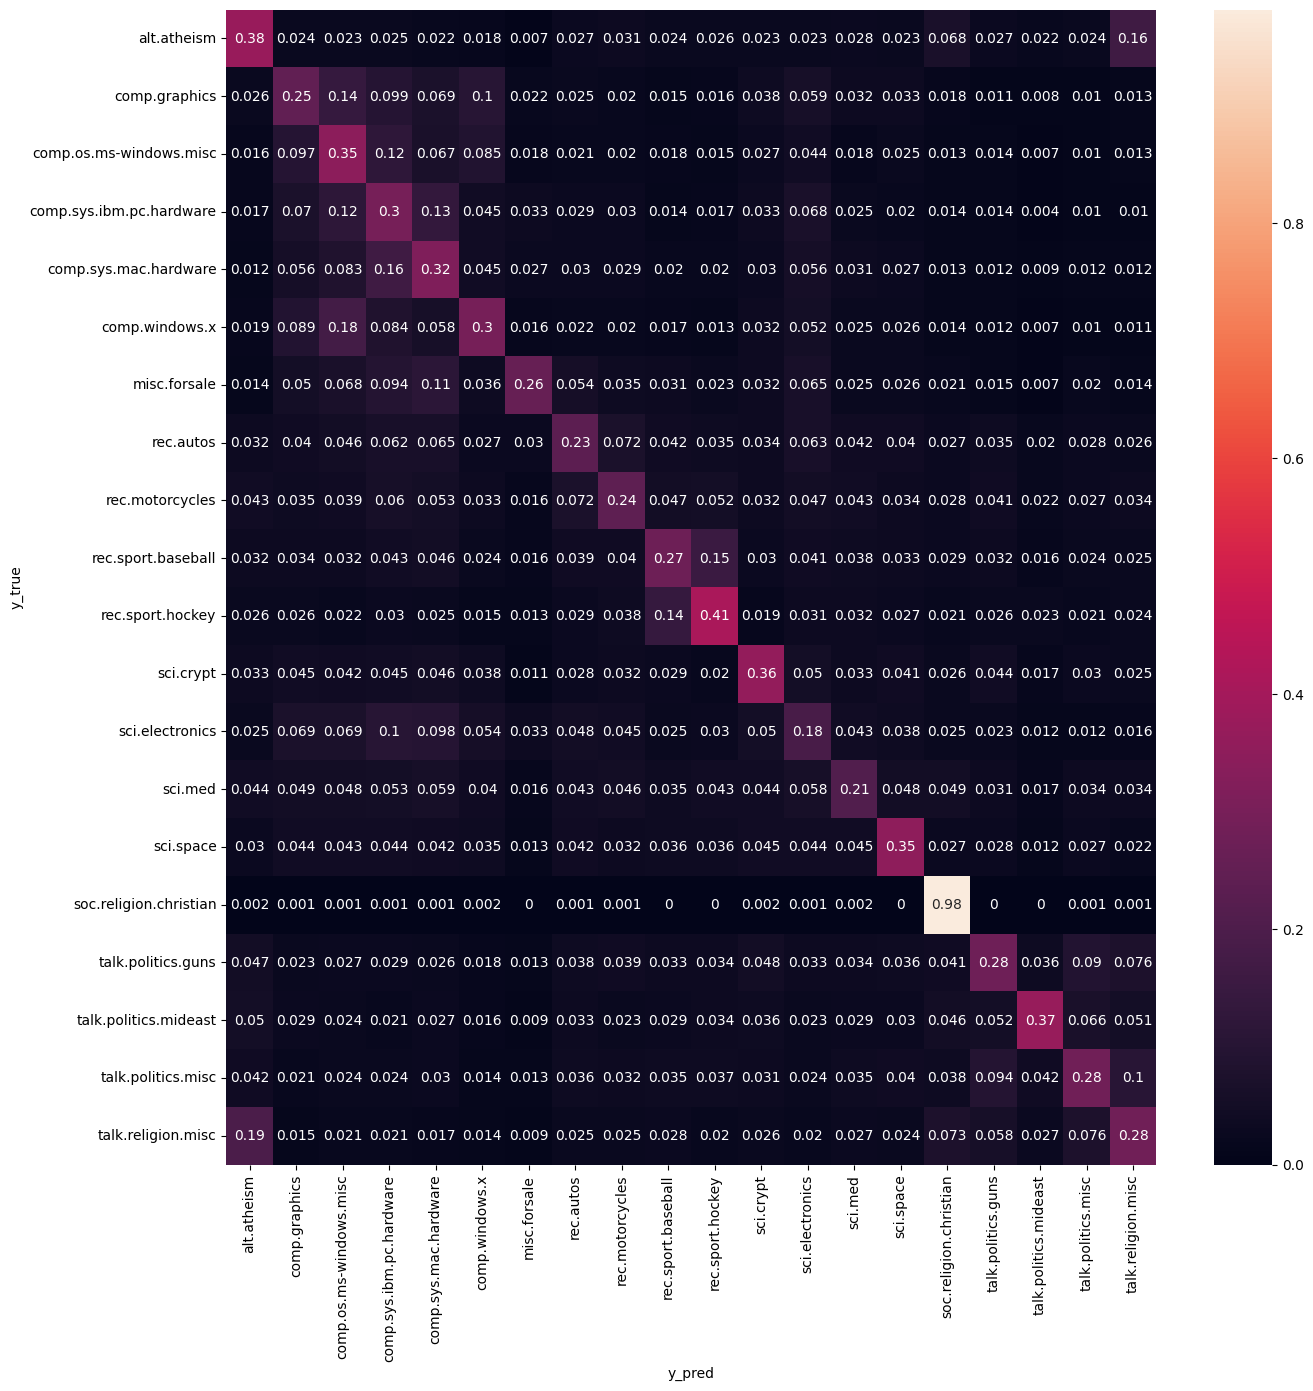

In [57]:
for prec in precisions_calc:
    v = pd.DataFrame(np.around(cf_per_prec_bm25[prec]/(cf_per_prec_bm25[prec].sum(axis=1)).reshape(-1, 1), 3), columns=labels, index=labels)
    
    fig = plt.figure(figsize=(15, 15))
    sns.heatmap(v, annot=True)
    plt.ylabel('y_true')
    plt.xlabel('y_pred')
    fig.savefig(f'figures/cf_matrix/cf_bm25_{prec}.png', bbox_inches='tight')

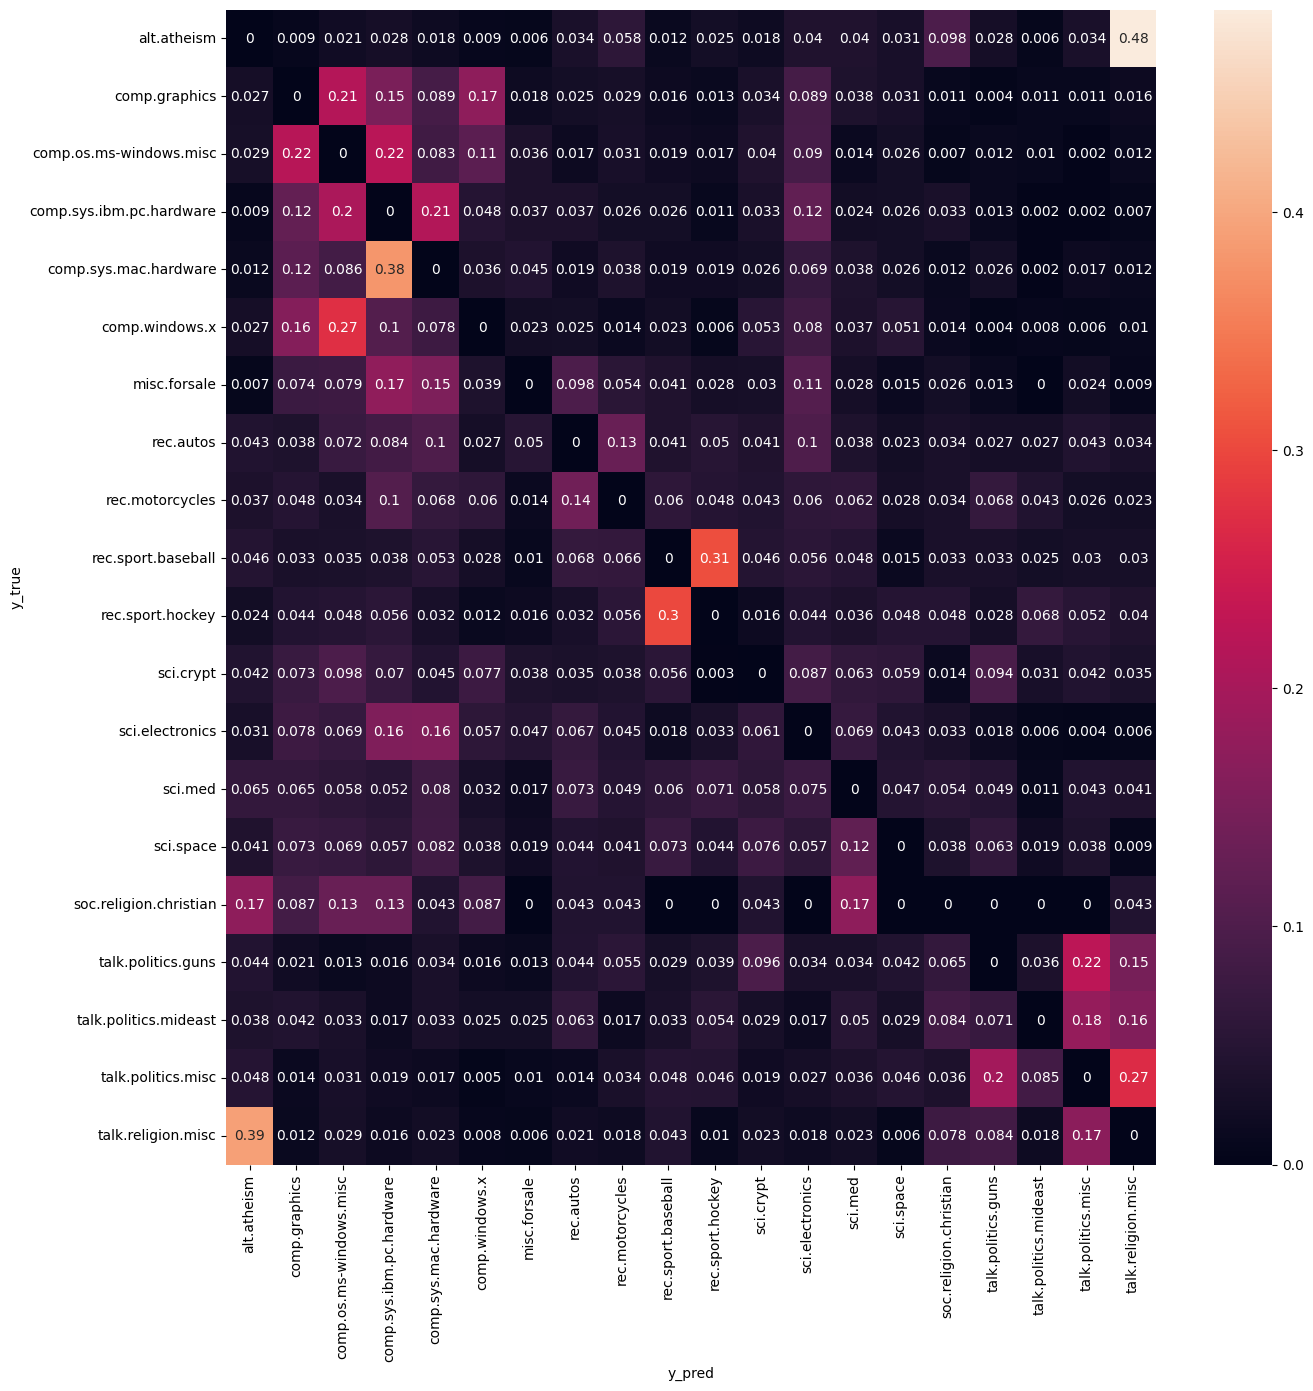

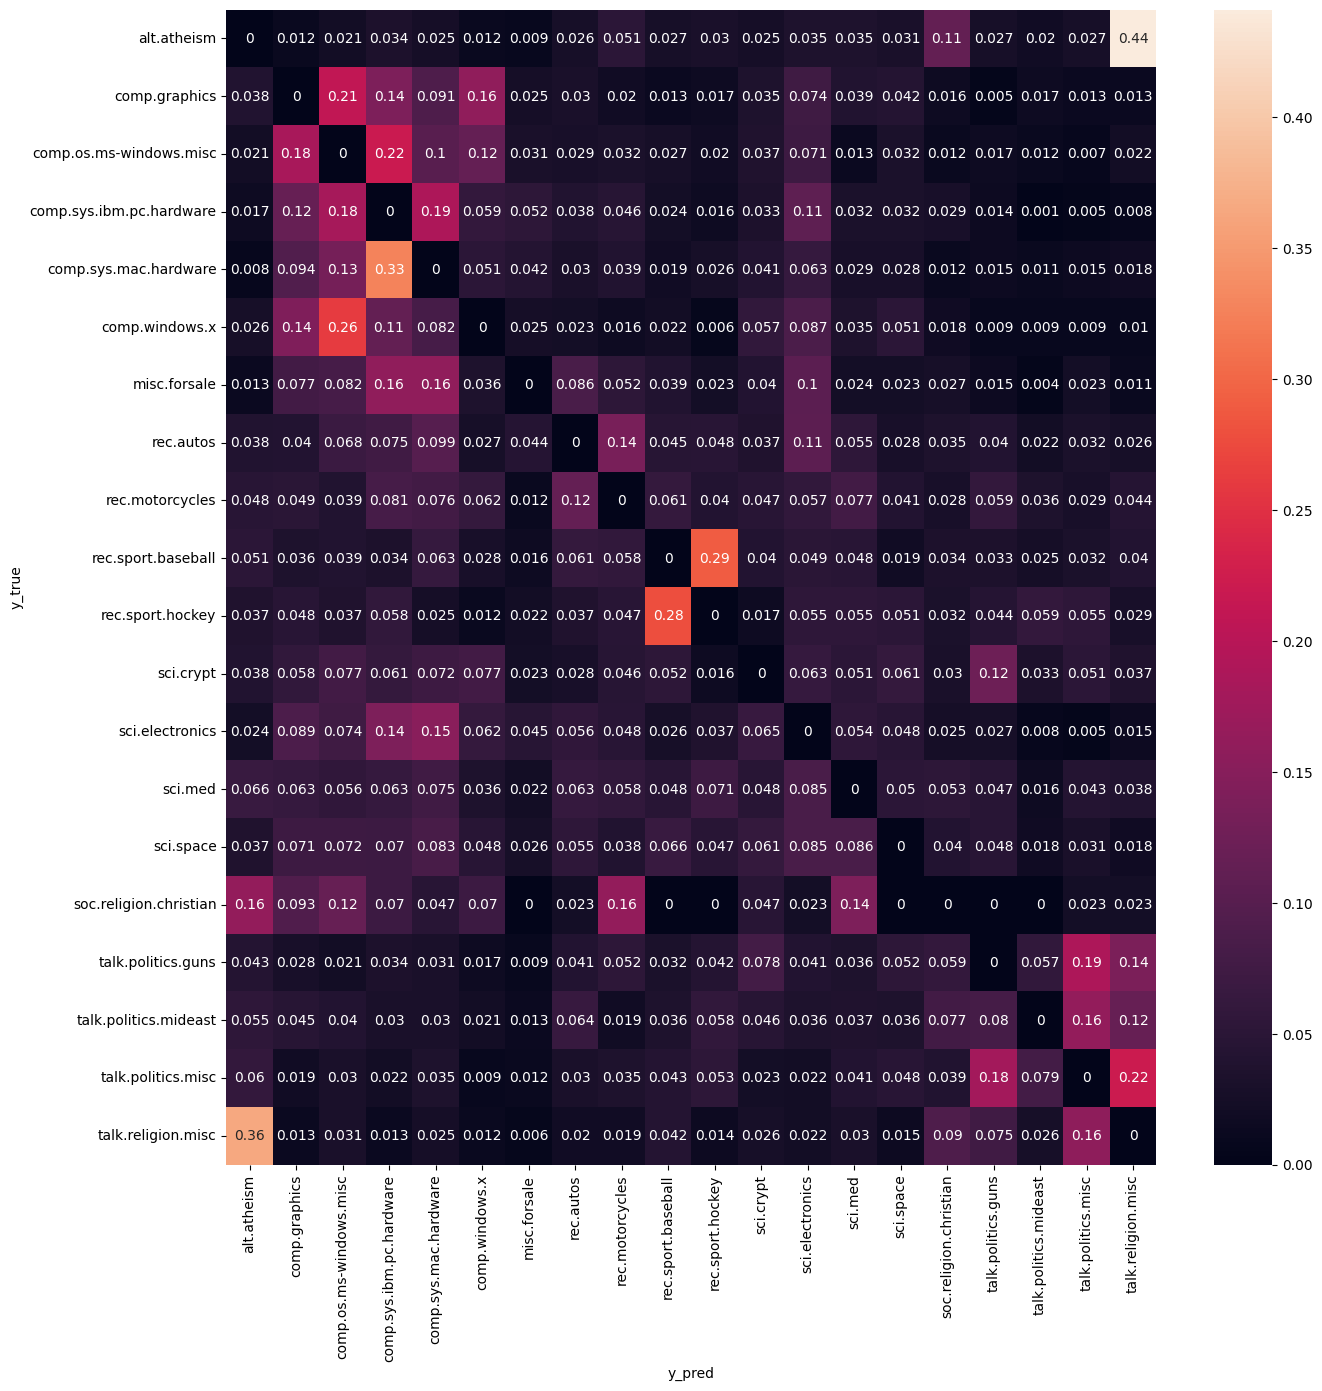

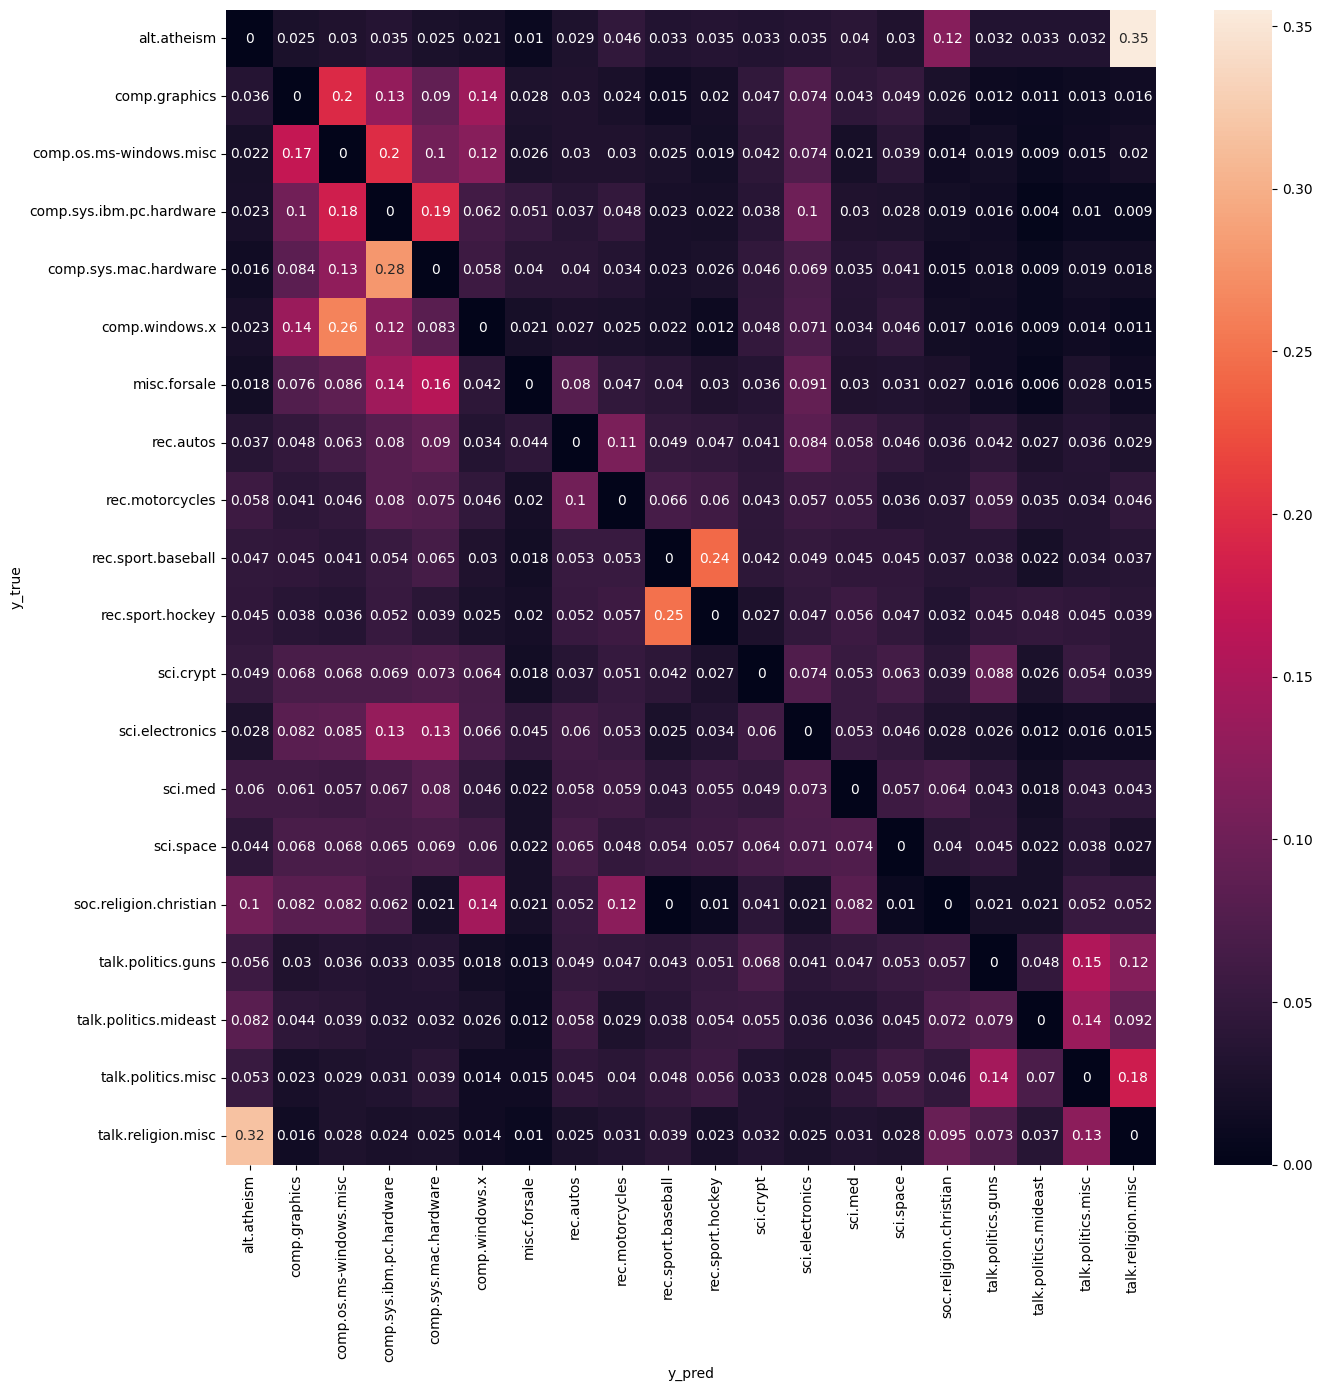

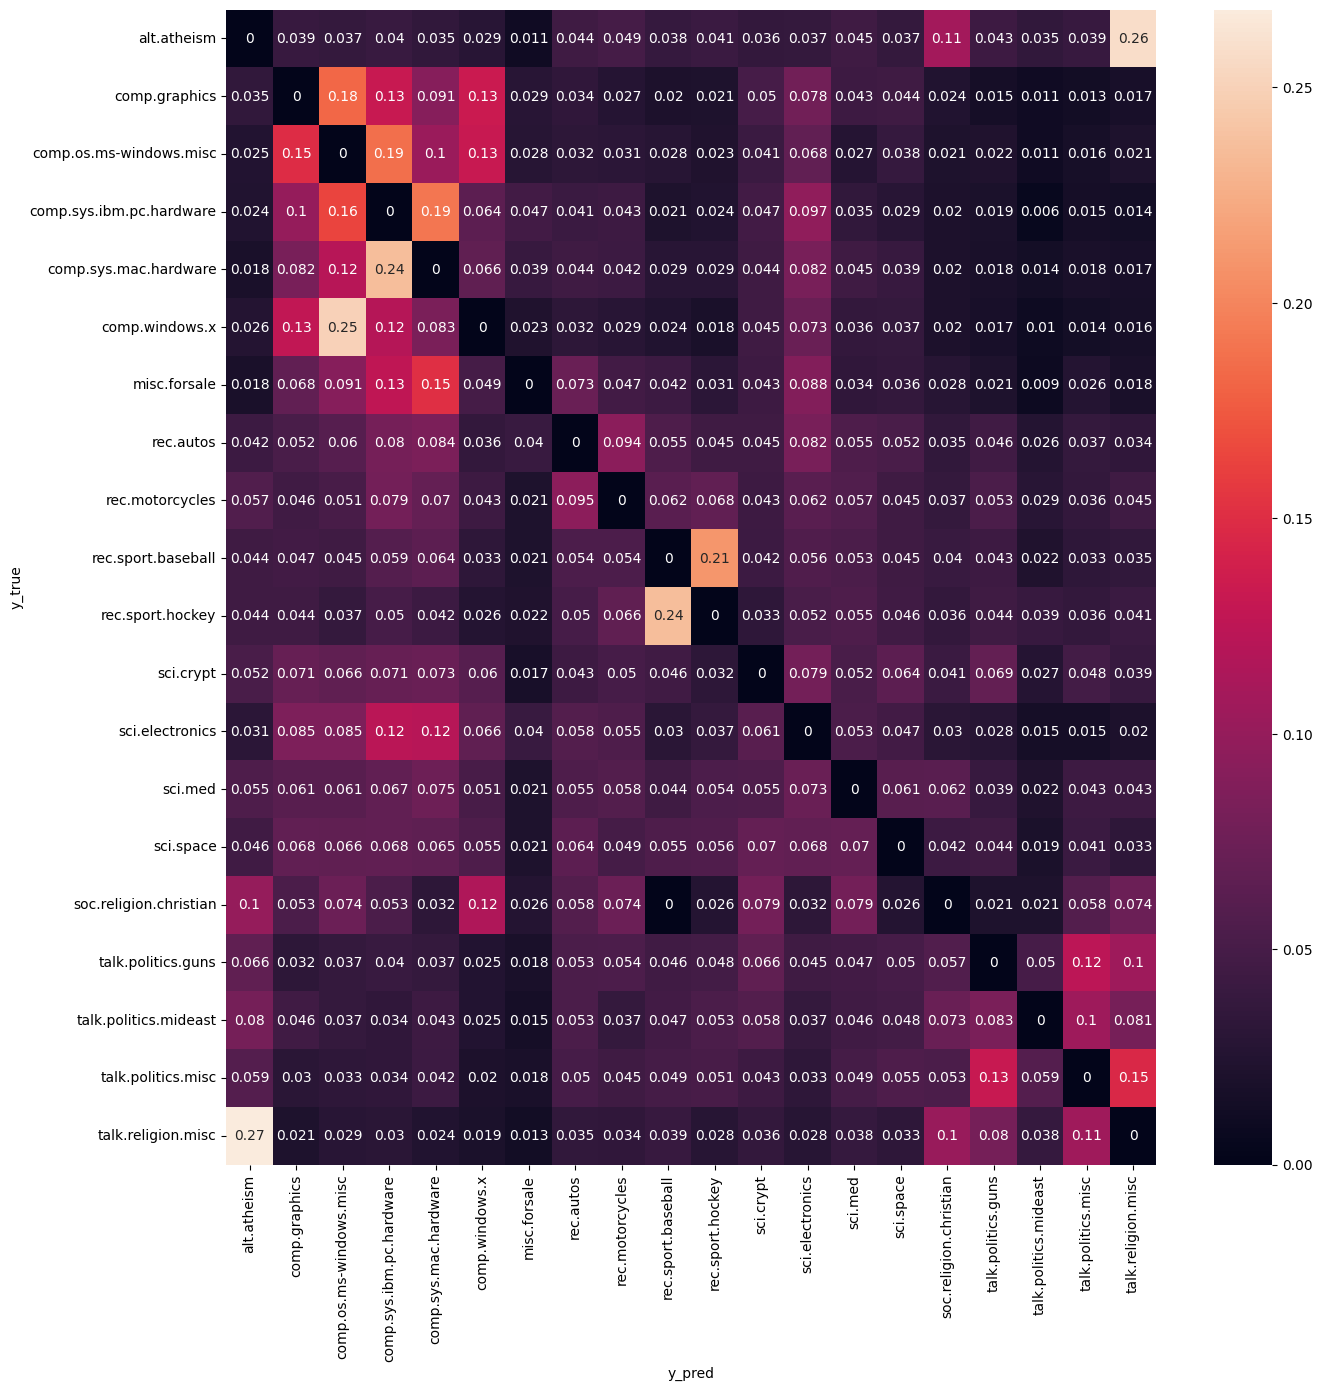

In [58]:
for prec in precisions_calc:
    v = pd.DataFrame(np.around(fill_diagonal(cf_per_prec_bm25[prec], 0)/(fill_diagonal(cf_per_prec_bm25[prec], 0).sum(axis=1)).reshape(-1, 1), 3), columns=labels, index=labels)
    
    fig = plt.figure(figsize=(15, 15))
    sns.heatmap(v, annot=True)
    plt.ylabel('y_true')
    plt.xlabel('y_pred')
    fig.savefig(f'figures/cf_matrix/cf_bm25_diagonal_0_{prec}.png', bbox_inches='tight')

### 2.3 Experimentando modelo com classe mais genérica

In [86]:
np.unique(y_test_generico)

array(['alt', 'comp', 'misc', 'rec', 'sci', 'soc', 'talk'], dtype='<U4')

In [59]:
y_generico = np.array([y_g.split('.')[0] for y_g in y])
y_test_generico = np.array([y_g.split('.')[0] for y_g in y_test])

labels = np.unique(y_generico)

model_bm25 = ModeloBM25()
model_bm25.fit(x=counter, y=np.array(y_generico))


predict_bm25 = []
for query_test in tfidf_test.values:
    predict_bm25.append(model_bm25.predict(query_test))

measures_bm25 = pd.DataFrame([calcula_measures(y_pred, y_true, precisions_calc + ['map']) for y_pred, y_true in zip(predict_bm25, y_test_generico)])


# Calculo das matrizes de confusão
cf_per_prec_bm25 = {}

for prec in precisions_calc:
    cf_per_prec_bm25[prec] = np.zeros(shape=(len(labels), len(labels)))

for y_pred, y_true in zip(predict_bm25, y_test_generico):
    for prec, cf in calcula_matriz_confusao(y_pred, y_true, precisions_calc, labels=np.unique(y_generico)).items():
        cf_per_prec_bm25[prec] += cf

r_vetorial_bm25 = pd.DataFrame(measures_bm25)

In [60]:
pd.DataFrame(r_vetorial_bm25.mean()).T

P@10      P@20      P@50     P@100       MAP
0  0.752603  0.679429  0.590811  0.527993  0.340852

In [61]:
r_vetorial_bm25.insert(0, 'Class', y_test_generico)
r_vetorial_bm25.groupby(by='Class').mean().sort_values(by='P@10', ascending=False)

P@10      P@20      P@50     P@100       MAP
Class                                                  
soc    0.977000  0.978500  0.980600  0.981000  0.956303
comp   0.821800  0.772600  0.722200  0.679400  0.447422
talk   0.772500  0.699750  0.589150  0.495825  0.245617
rec    0.752764  0.659422  0.547387  0.479121  0.301687
sci    0.683250  0.582500  0.475100  0.411800  0.265893
alt    0.674000  0.597500  0.473800  0.374700  0.192594
misc   0.458000  0.382500  0.303400  0.259200  0.177461

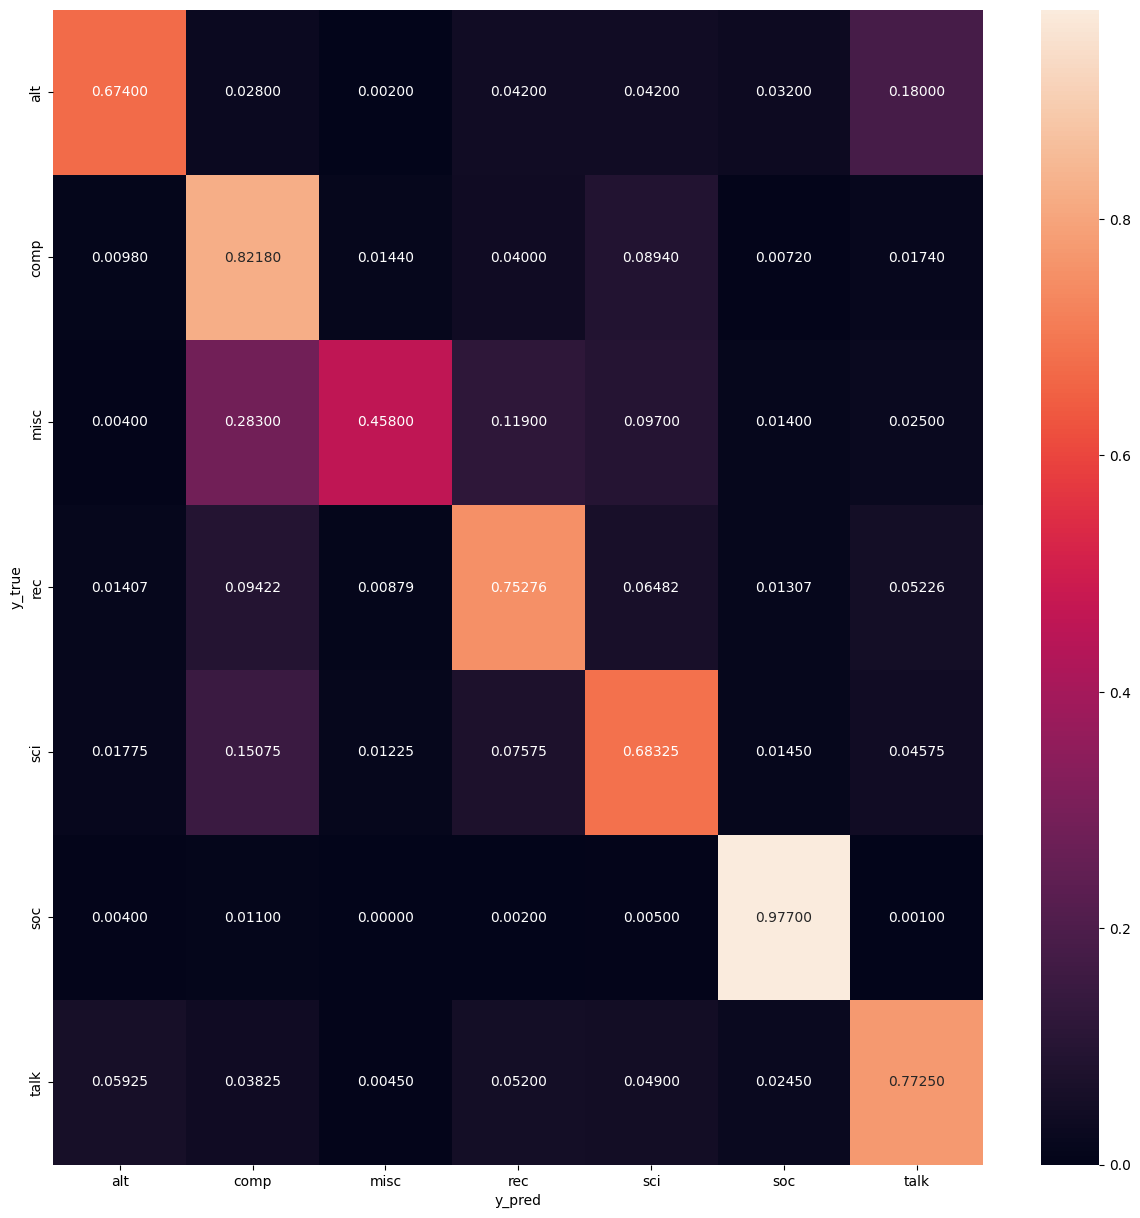

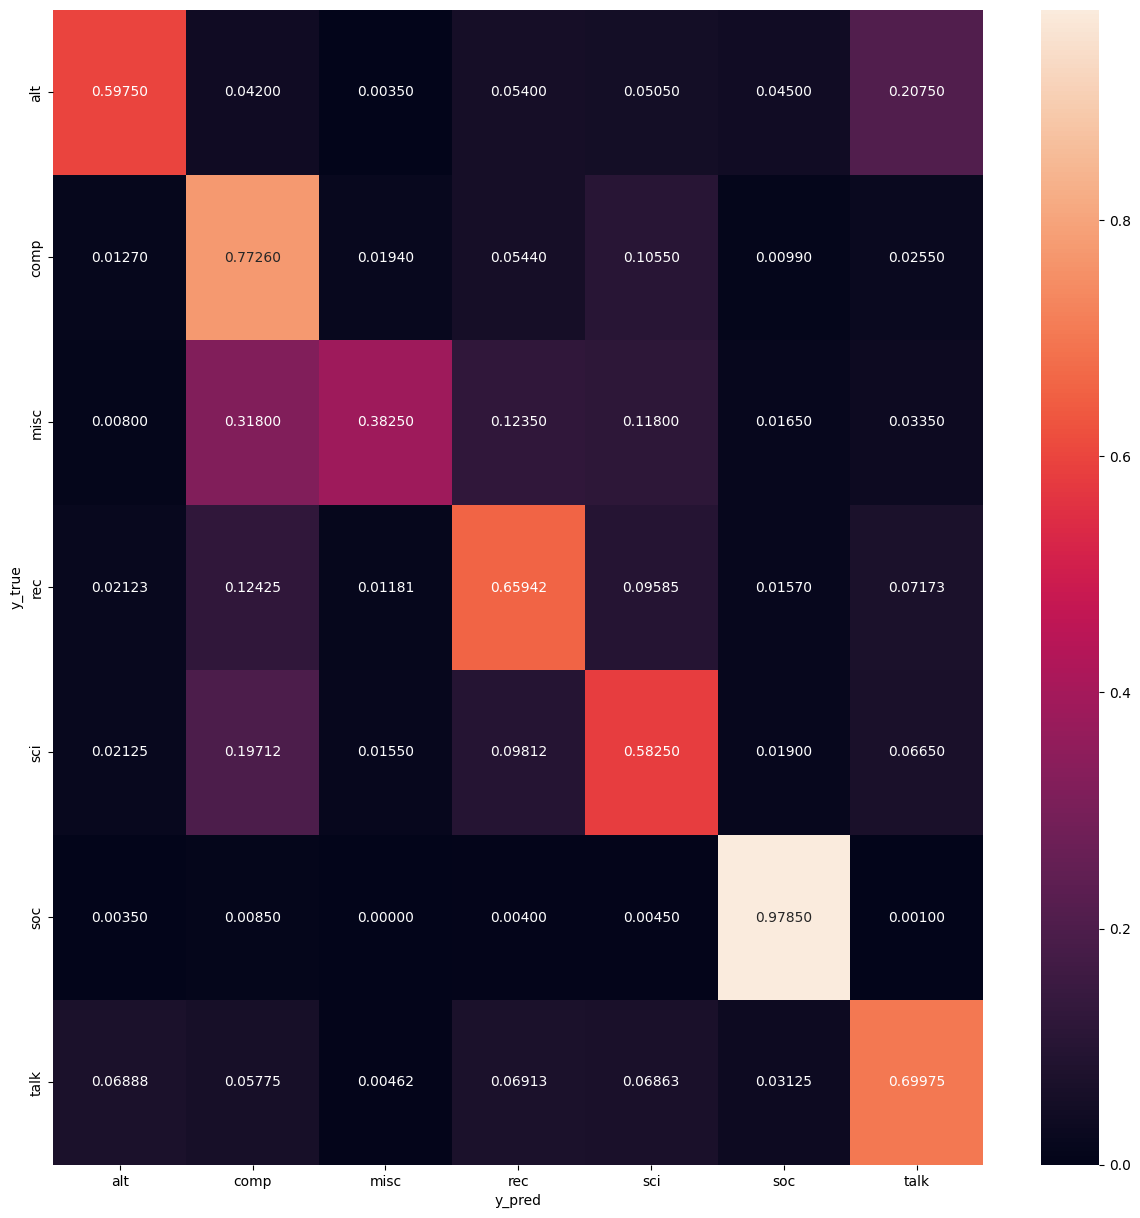

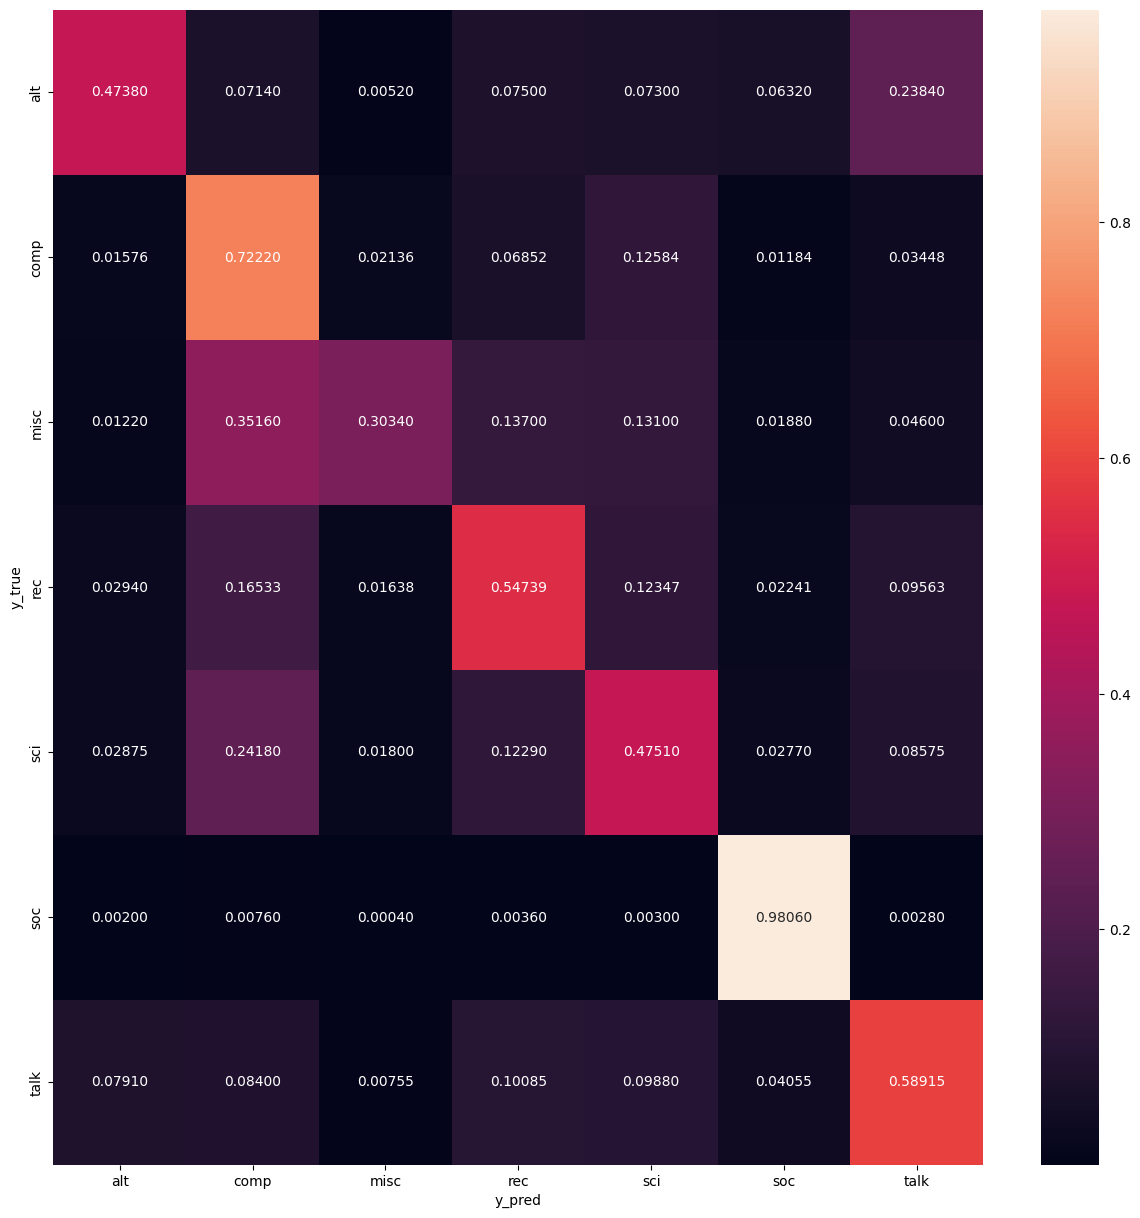

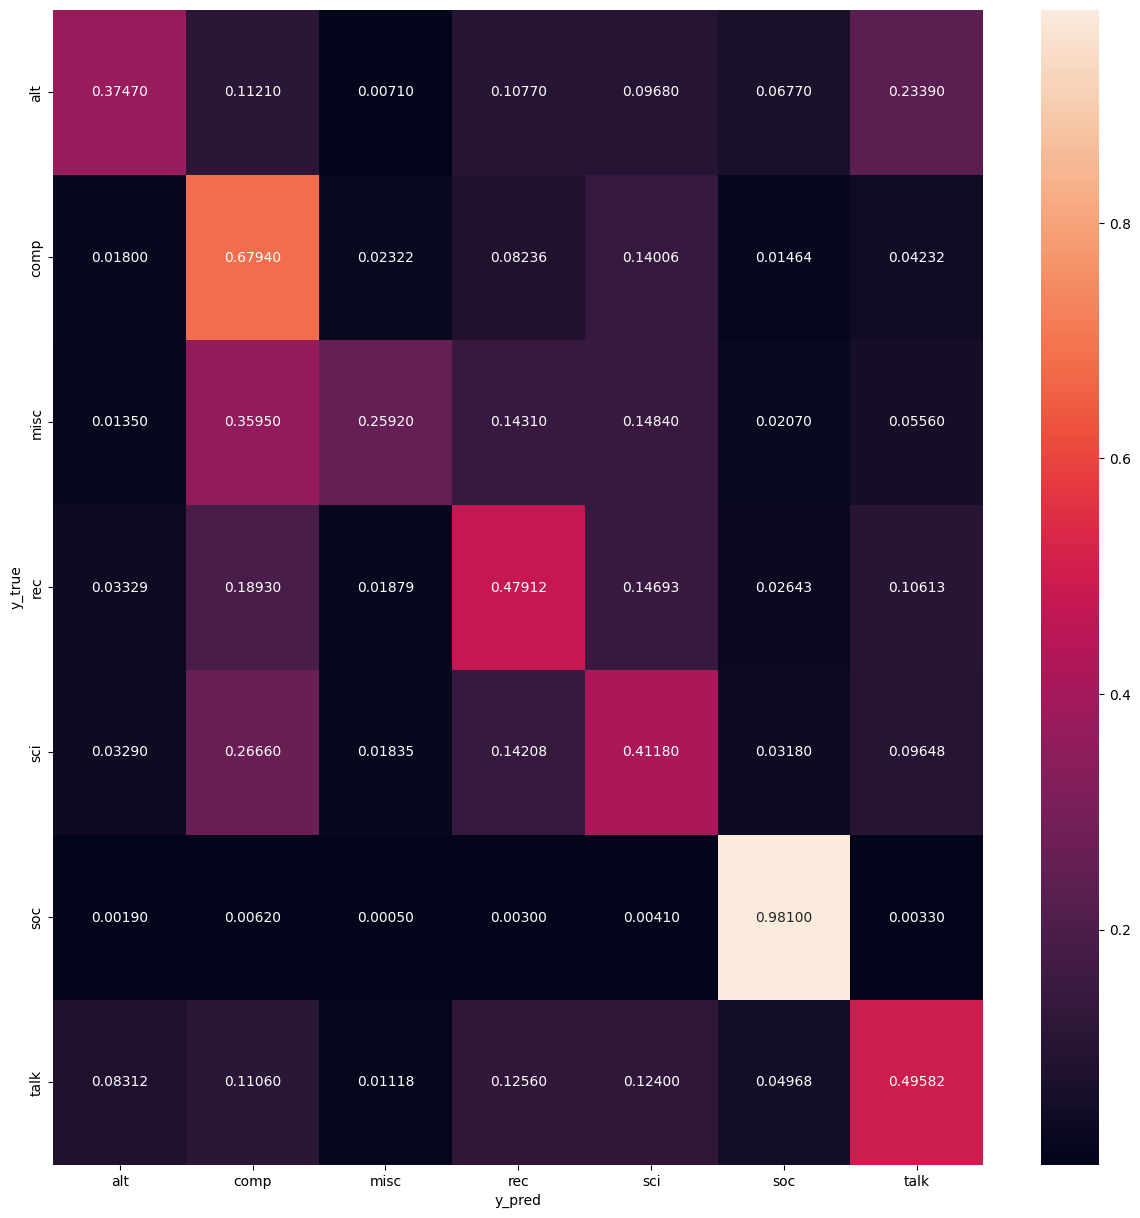

In [62]:
for prec in precisions_calc:
    v = pd.DataFrame(np.around(cf_per_prec_bm25[prec]/(cf_per_prec_bm25[prec].sum(axis=1)).reshape(-1, 1), 5), columns=labels, index=labels)
    
    fig = plt.figure(figsize=(15, 15))
    sns.heatmap(v, annot=True, fmt=".5f")
    plt.ylabel('y_true')
    plt.xlabel('y_pred')
    fig.savefig(f'figures/cf_matrix_generico/cf_bm25_{prec}.png', bbox_inches='tight')

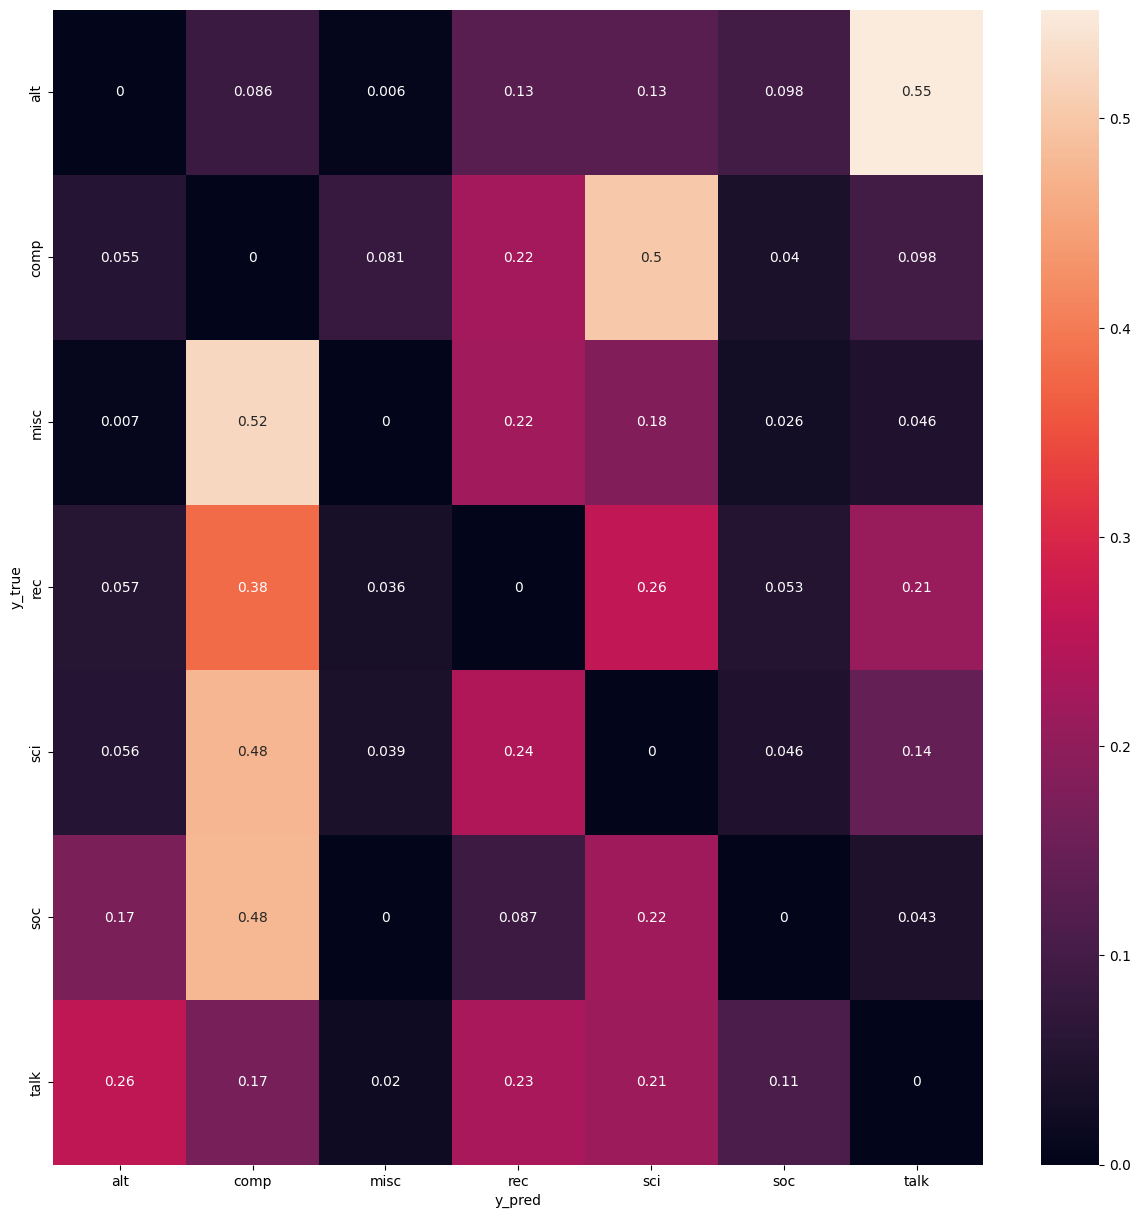

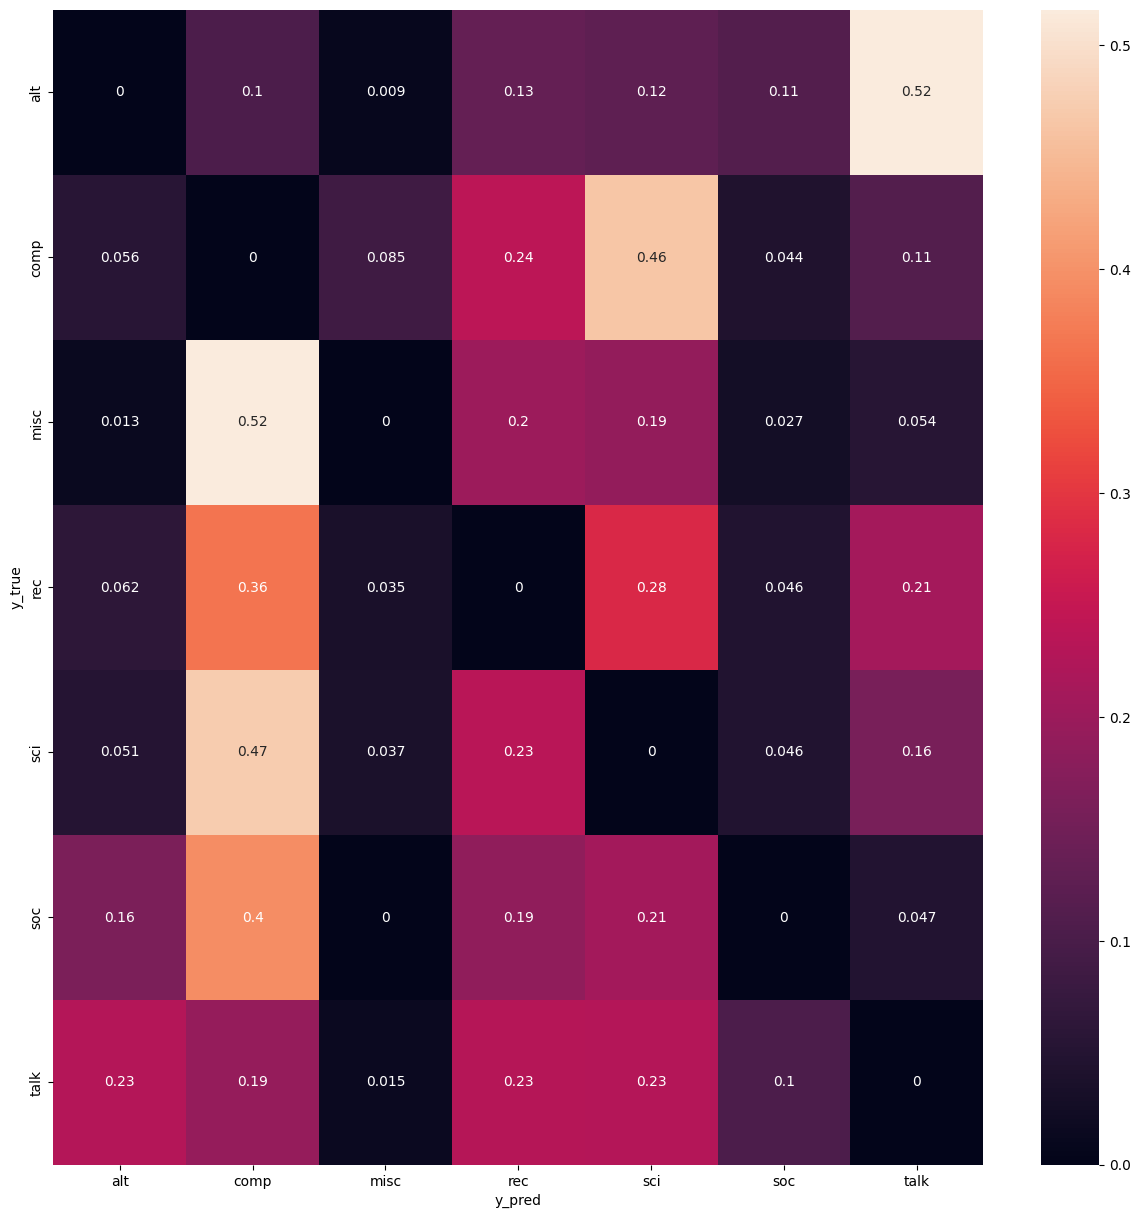

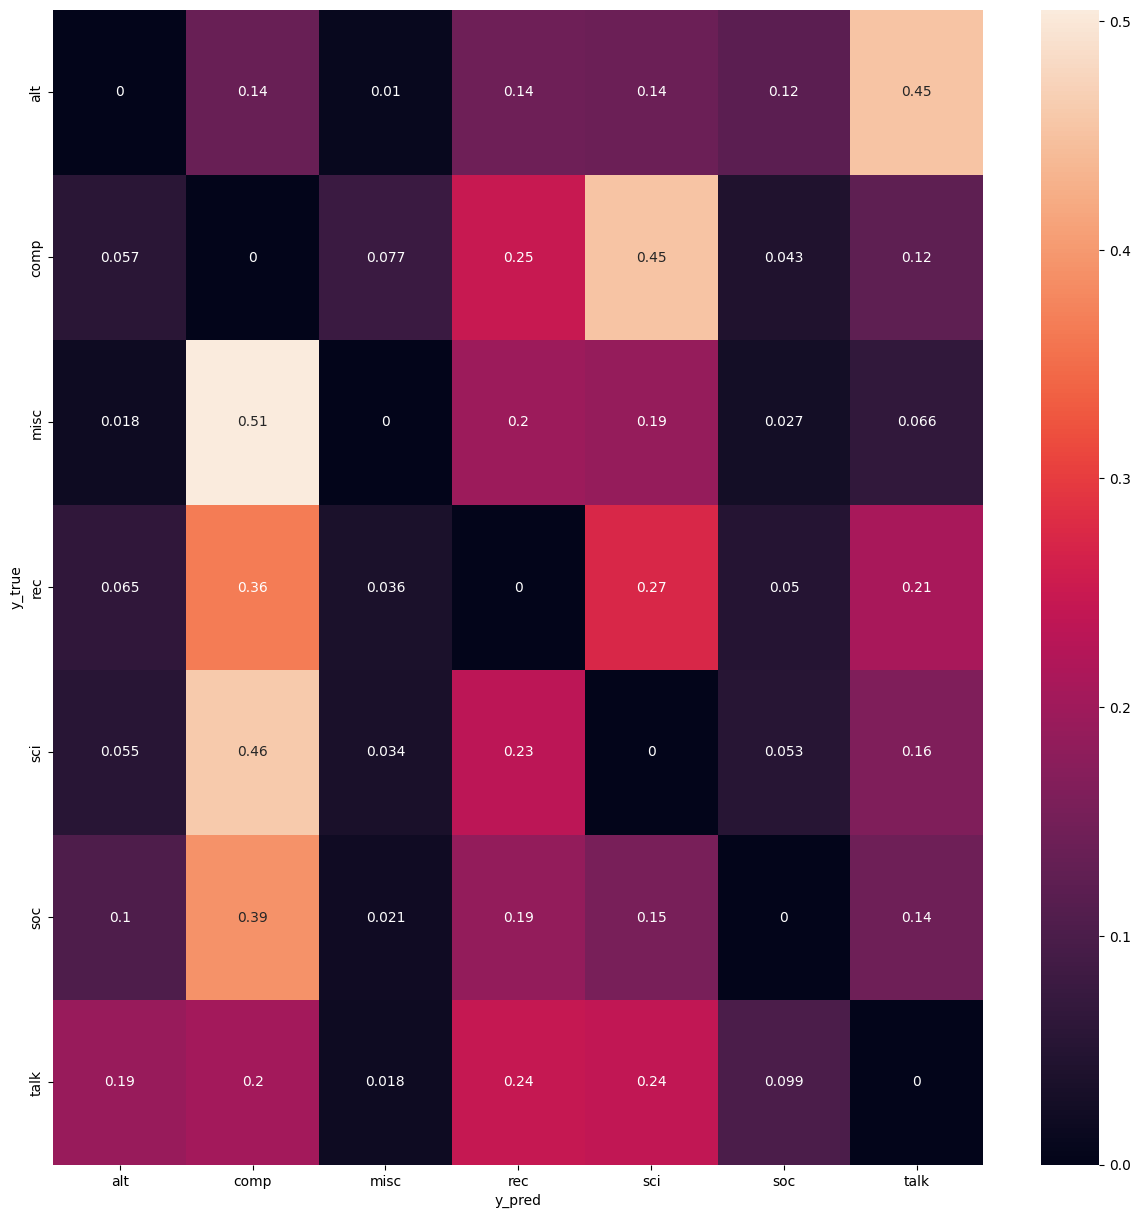

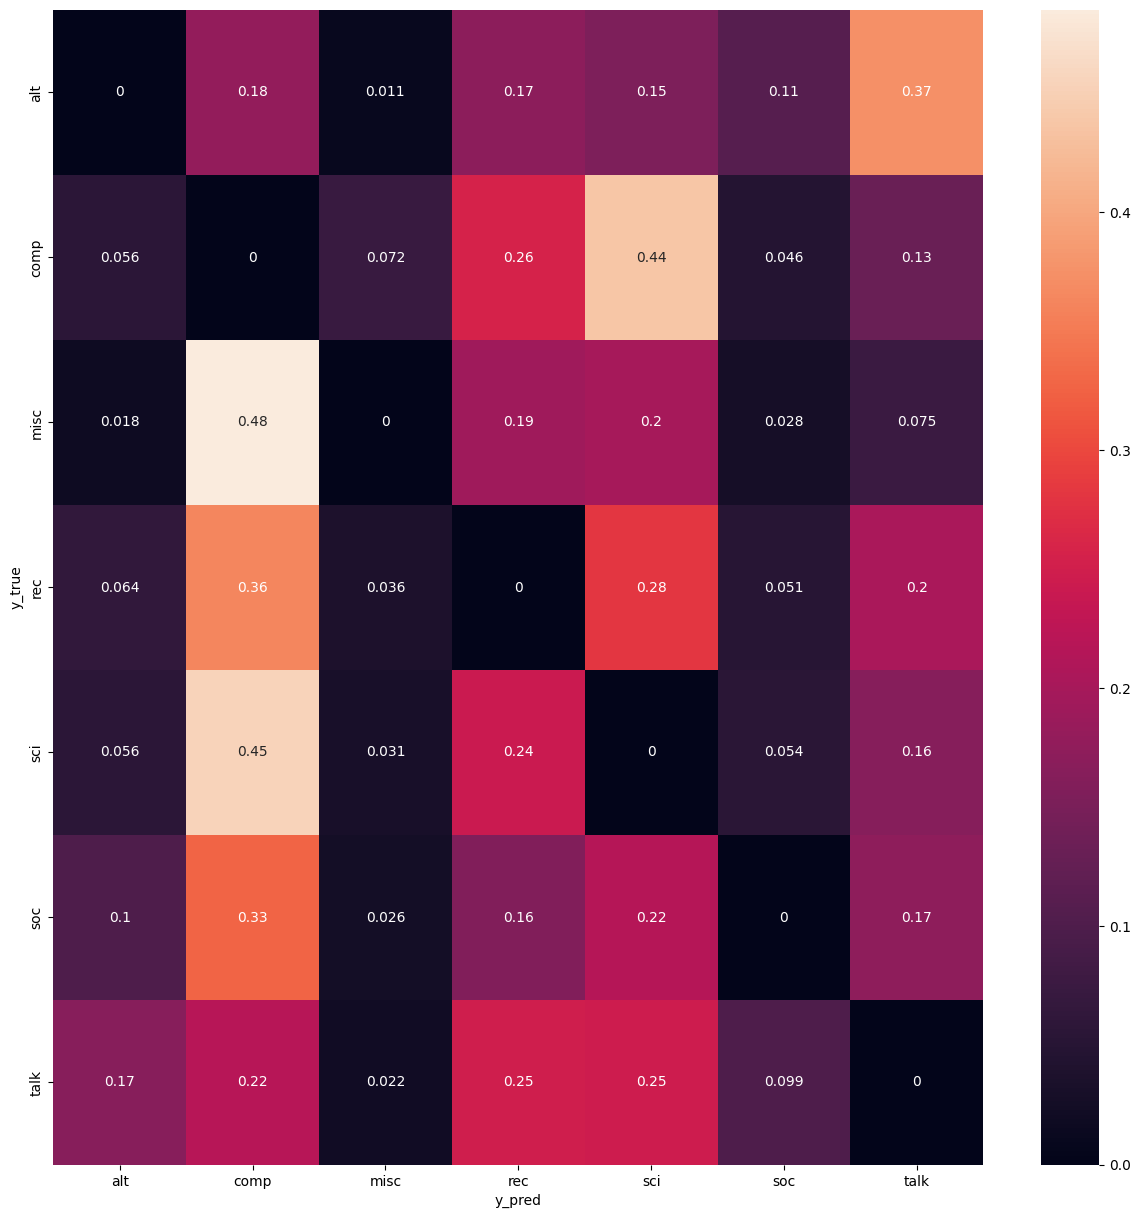

In [63]:
for prec in precisions_calc:
    v = pd.DataFrame(np.around(fill_diagonal(cf_per_prec_bm25[prec], 0)/fill_diagonal(cf_per_prec_bm25[prec], 0).sum(axis=1).reshape(-1, 1), 3), columns=labels, index=labels)
    
    fig = plt.figure(figsize=(15, 15))
    sns.heatmap(v, annot=True)
    plt.ylabel('y_true')
    plt.xlabel('y_pred')
    fig.savefig(f'figures/cf_matrix_generico/cf_bm25_diagonal_0_{prec}.png', bbox_inches='tight')